In [1685]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, conv1d, relu_, unfold, fold
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
from sklearn.linear_model import LinearRegression

from htmresearch.frameworks.cans.utils import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1686]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [1687]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [1725]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


def mexican_hat(x, sigma=1.):
    a = 2./(np.sqrt(3*sigma)*np.power(np.pi, 0.25))
    b = (1. - (x/(.8*sigma))**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [1739]:
class GCN1D(object):
    
    def __init__(self,
                 numX,
                 inhibitionWindow,
                 inhibitionRadius,                 
                 inhibitionStrength,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.001,
                 numPlaces=200,
                 placeAlpha=20,
                 globalTonic=20,
                 tonicGradientX=0.,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactor=.9,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                 weightFunction=mexican_hat,
                 normalize=False,
                 weightNoise=None,
                ):
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow], dtype=torch.float,
                                 device=device)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow], dtype=torch.float, device=device)
        self.inhibitoryWeights=torch.randn(1, 2*inhibitionWindow+1, numX,
                        device=device, dtype=torch.float)
        
        self.numX = numX
        self.numPlaces=numPlaces
        
                
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)
        self.smoothingKernel /= size
        self.smoothingWindow = (smoothingWindow, )
            
        
        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = weightFunction(dist/inhibitionRadius)*inhibitionStrength
                self.filter[0, 0, i] = weight
                self.inhibitoryWeights[:, i, :] = weight
                
        if weightNoise is not None:
            mask = torch.zeros((1, 2*inhibitionWindow+1, self.numX), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
            
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(0, boostGradientX, numX)
            decayGradient = np.linspace(0., decayGradientX, numX)
            tonicGradient = np.linspace(0., tonicGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            print(upper, 1./gradientType, boostGradientX)
            gradient = np.power(np.linspace(0., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(0., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(0., tonicUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(
            gradient + boostEffect, device=device, dtype=torch.float)
        self.alpha = torch.tensor(
            decayGradient + boostDecay, device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(
            tonicGradient + globalTonic, device=device, dtype=torch.float)
        
        self.dt = dt
        self.decay = decayConstant
        self.placeAlpha = placeAlpha
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.negativeLearnFactor = negativeLearnFactor
        self.weightDecay = weightDecay
        self.normalize = normalize
        
        self.kernel = ((2*inhibitionWindow+1), 1)
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self, speed=1, place=True, alphaboost=0.): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
            
        self.instantaneous += localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                 self.inhibitoryWeights,
                                                 self.kernel).view(1, 1, self.numX)
        
        #self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        self.instantaneous += self.activationHistory * self.boostEffect
        #self.instantaneous *= min(speed, 1)
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        #self.activationHistory += ( - self.activity)*self.dt*self.envelope
        alpha = torch.max(self.alpha, self.zero+alphaboost)
        self.activationHistory = alpha*self.dt*(torch.mean(self.activity) - self.activity) +\
                                 (1. - alpha*self.dt)*self.activationHistory
        
        if torch.sum(self.activity**2) > 0 and self.normalize:
            self.activity = self.activity/torch.sqrt(torch.sum(self.activity**2))
        
    def simulate(self, time, logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
        
        self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False, alphaboost=alphaboost)
            alphaboost /= 1.1
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                histOutput[s].copy_(self.activationHistory.view(self.numX))
                s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    def decayWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    def learn(self, runs, plotting=True, plotInterval=100, runLength = 10, offsets=(0,0), randomSpeed=False,
              wrap=False):
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        # Space the starting points of the runs out.  This tends to improve the
        # translation-invariance of the weight profiles, and thus gives better
        # overall path integration.
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
        for run in range(runs):
            if randomSpeed:
                speed = np.random.random() + 0.5
            else:
                speed = 1.
            
            if np.random.random() > 0.5:
                direction = 1
            else:
                direction = -1.
            length = 2*self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = (np.sin((runTimes * np.pi * direction / (self.envSize / speed) - np.pi / 2.)) + 1) * \
            self.envSize/2.
            #trajectory = np.linspace(0, direction*length, len(runTimes))
            trajectories.append(trajectory)
            timings.append(runTimes + time)
            time += length
            startingPoint += 1. / runs
        
        for run, (trajectory, times) in enumerate(zip(trajectories, timings)):
            print("Starting run {}".format(run))
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                         dtype=torch.float)
            self.activationHistory.fill_(0.)
            self.simulate(100, logFreq=100000, startFrom=10000)
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = min(speed[i]/torch.mean(speed), 1.)**5
                if wrap:
                    distances = torch.min(torch.abs(self.places - pos),
                                          torch.abs(self.envSize - self.places + pos))
                else:
                    distances = torch.abs(self.places - pos)
                    
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.placeHistory = -self.placeAlpha*self.dt*self.placeActivity +\
                         (1. - self.placeAlpha*self.dt)*self.placeHistory
                self.step(speed=s)
                self.stdpUpdate(i)
                #self.bcmPlaceUpdate()
                torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                torch.min(self.placeWeights, self.zero + 2., out=self.placeWeights)
                self.placeWeights *= .5/torch.mean(self.placeWeights, -1, keepdim=True)
                #self.decayWeights()
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()
            self.stdpUpdate(i, clearBuffer=True)

    def bcmPlaceUpdate(self):
        update = self.dt*self.learningRate*(torch.ger(self.activity.view(self.numX),
                                                    self.placeActivity) -\
                                               torch.ger(self.activationHistory.view(self.numX),
                                                    self.placeHistory)).view(self.numX, self.numPlaces)
        update = torch.transpose(update, 0, -1)
        update = update.view(self.numPlaces, 1, self.numX)
        update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
        update = update.view(self.numPlaces, self.numX)
        update = torch.transpose(update, 0, -1)
        self.placeWeights += update 
                                                      
    def stdpUpdate(self, time, clearBuffer=False):
        if time < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                update = torch.ger(self.activity.view(self.numX), self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces)
                update -= (torch.ger(self.activityBuffer[i], self.placeActivity) *\
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                      self.negativeLearnFactor
                
                update = torch.transpose(update, 0, -1)
                update = update.view(self.numPlaces, 1, self.numX)
                update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
                update = update.view(self.numPlaces, self.numX)
                update = torch.transpose(update, 0, -1)
                self.placeWeights += update 


            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            
            
        if clearBuffer:
            for j in range(self.stdpWindow):
                for t in range(self.stdpWindow):
                    i = (j + self.bufferIndex - t) % self.stdpWindow
                    update = torch.ger(self.activityBuffer[j], self.placeBuffer[i]* \
                                            self.stdpValues[t]).view(self.numX, self.numPlaces)
                    update -= (torch.ger(self.activityBuffer[i], self.placeBuffer[j]) *\
                                            self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                          self.negativeLearnFactor
                    
                    update = torch.transpose(update, 0, -1)
                    update = update.view(self.numPlaces, 1, self.numX)
                    update = conv1d(update, self.smoothingKernel, padding=self.smoothingWindow)
                    update = update.view(self.numPlaces, self.numX)
                    update = torch.transpose(update, 0, -1)
                    self.placeWeights += update 

                self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
                self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX,))
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)



<IPython.core.display.Javascript object>


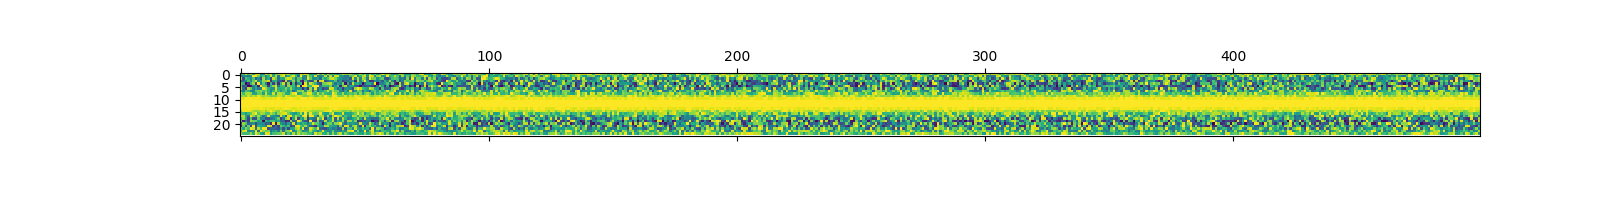

<IPython.core.display.Javascript object>


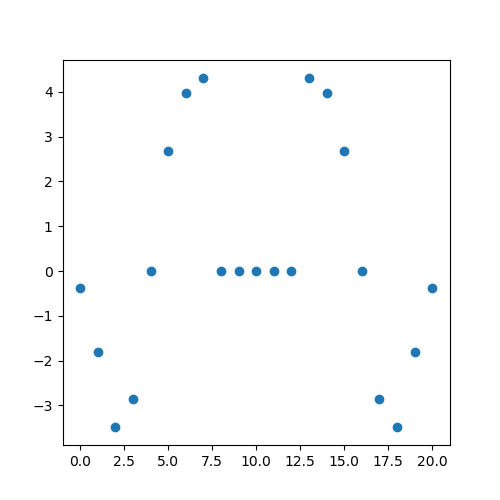

<IPython.core.display.Javascript object>


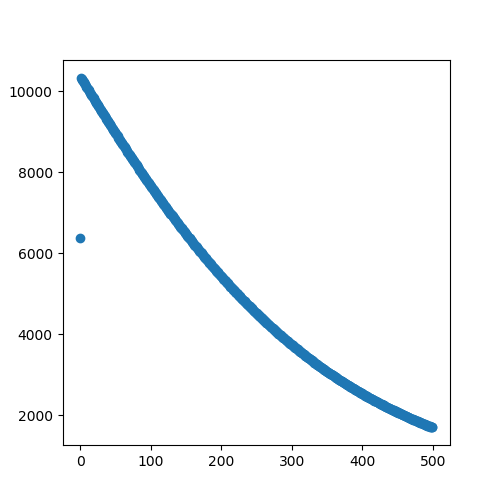

In [1750]:
plt.rcParams['figure.figsize'] = [5, 5]

hatGCN = GCN1D(500,
            10,
            20.,
            5.,
            globalTonic=.025,
            tonicGradientX=0,
            stdpWindow=1,
            dt=0.01,
            boostEffect=.5,
            boostDecay=1.,
            placeAlpha=100.,
            decayConstant=.5,
            numPlaces=500,
            learningRate=100.,
            initialWeightFactor=.02,
            boostGradientX=19.5,
            decayGradientX=0.,
            weightDecay=500,
            wideningFactor=2,
            negativeLearnFactor=.9,
            envelopeWidth=10,
            envelopeFactor=2,
            sigmaLoc=.0005,
            gradientType="exponential",
            envSize=5.,
            weightFunction=mexican_hat,
            normalize=True,
            weightNoise=2.)

inhibGCN = GCN1D(500,
            12,
            .8,
            100.,
            globalTonic=1.,
            tonicGradientX=0,
            stdpWindow=1,
            dt=0.05,
            boostEffect=.5,
            boostDecay=.5,
            placeAlpha=100.,
            decayConstant=.3,
            numPlaces=500,
            learningRate=100.,
            initialWeightFactor=.02,
            boostGradientX=19.5,
            decayGradientX=0.,
            weightDecay=500,
            wideningFactor=1.,
            negativeLearnFactor=.9,
            envelopeWidth=10,
            envelopeFactor=2,
            sigmaLoc=.0005,
            gradientType="exponential",
            envSize=5.,
            weightFunction=w_0,
            normalize=False,
            weightNoise=2.)


#GCN.randomLesions(10, 10, 5)

plt.matshow(inhibGCN.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(hatGCN.filter.shape[-1]), hatGCN.filter[0, :])
plt.show()
# plt.matshow(GCN.envelope)
# plt.show()

# plt.figure()
# plt.scatter(np.arange(GCN.numX), GCN.boostEffect)
# plt.show()


plt.figure()
plt.scatter(np.arange(hatGCN.numX), fit_fn(1./(hatGCN.alpha*hatGCN.boostEffect))**0.7)
plt.show()


In [1751]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults = inhibGCN.simulate(2000, logFreq=int(0.05/GCN.dt), startFrom = 0.)

At 0.0
At 0.05
At 0.1
At 0.15000000000000002
At 0.2
At 0.25
At 0.30000000000000004
At 0.35000000000000003
At 0.4
At 0.45
At 0.5
At 0.55
At 0.6000000000000001
At 0.65
At 0.7000000000000001
At 0.75
At 0.8
At 0.8500000000000001
At 0.9
At 0.9500000000000001
At 1.0
At 1.05
At 1.1
At 1.1500000000000001
At 1.2000000000000002
At 1.25
At 1.3
At 1.35
At 1.4000000000000001
At 1.4500000000000002
At 1.5
At 1.55
At 1.6
At 1.6500000000000001
At 1.7000000000000002
At 1.75
At 1.8
At 1.85
At 1.9000000000000001
At 1.9500000000000002
At 2.0
At 2.0500000000000003
At 2.1
At 2.15
At 2.2
At 2.25
At 2.3000000000000003
At 2.35
At 2.4000000000000004
At 2.45
At 2.5
At 2.5500000000000003
At 2.6
At 2.6500000000000004
At 2.7
At 2.75
At 2.8000000000000003
At 2.85
At 2.9000000000000004
At 2.95
At 3.0
At 3.0500000000000003
At 3.1
At 3.1500000000000004
At 3.2
At 3.25
At 3.3000000000000003
At 3.35
At 3.4000000000000004
At 3.45
At 3.5
At 3.5500000000000003
At 3.6
At 3.6500000000000004
At 3.7
At 3.75
At 3.8000000000000003


At 34.7
At 34.75
At 34.800000000000004
At 34.85
At 34.9
At 34.95
At 35.0
At 35.050000000000004
At 35.1
At 35.15
At 35.2
At 35.25
At 35.300000000000004
At 35.35
At 35.4
At 35.45
At 35.5
At 35.550000000000004
At 35.6
At 35.65
At 35.7
At 35.75
At 35.800000000000004
At 35.85
At 35.9
At 35.95
At 36.0
At 36.050000000000004
At 36.1
At 36.15
At 36.2
At 36.25
At 36.300000000000004
At 36.35
At 36.4
At 36.45
At 36.5
At 36.550000000000004
At 36.6
At 36.65
At 36.7
At 36.75
At 36.800000000000004
At 36.85
At 36.9
At 36.95
At 37.0
At 37.050000000000004
At 37.1
At 37.15
At 37.2
At 37.25
At 37.300000000000004
At 37.35
At 37.4
At 37.45
At 37.5
At 37.550000000000004
At 37.6
At 37.65
At 37.7
At 37.75
At 37.800000000000004
At 37.85
At 37.9
At 37.95
At 38.0
At 38.050000000000004
At 38.1
At 38.15
At 38.2
At 38.25
At 38.300000000000004
At 38.35
At 38.400000000000006
At 38.45
At 38.5
At 38.550000000000004
At 38.6
At 38.650000000000006
At 38.7
At 38.75
At 38.800000000000004
At 38.85
At 38.900000000000006
At 38.9

At 65.8
At 65.85000000000001
At 65.9
At 65.95
At 66.0
At 66.05
At 66.10000000000001
At 66.15
At 66.2
At 66.25
At 66.3
At 66.35000000000001
At 66.4
At 66.45
At 66.5
At 66.55
At 66.60000000000001
At 66.65
At 66.7
At 66.75
At 66.8
At 66.85000000000001
At 66.9
At 66.95
At 67.0
At 67.05
At 67.10000000000001
At 67.15
At 67.2
At 67.25
At 67.3
At 67.35000000000001
At 67.4
At 67.45
At 67.5
At 67.55
At 67.60000000000001
At 67.65
At 67.7
At 67.75
At 67.8
At 67.85000000000001
At 67.9
At 67.95
At 68.0
At 68.05
At 68.10000000000001
At 68.15
At 68.2
At 68.25
At 68.3
At 68.35000000000001
At 68.4
At 68.45
At 68.5
At 68.55
At 68.60000000000001
At 68.65
At 68.7
At 68.75
At 68.8
At 68.85000000000001
At 68.9
At 68.95
At 69.0
At 69.05
At 69.10000000000001
At 69.15
At 69.2
At 69.25
At 69.3
At 69.35000000000001
At 69.4
At 69.45
At 69.5
At 69.55
At 69.60000000000001
At 69.65
At 69.7
At 69.75
At 69.8
At 69.85000000000001
At 69.9
At 69.95
At 70.0
At 70.05
At 70.10000000000001
At 70.15
At 70.2
At 70.25
At 70.3
At

At 102.45
At 102.5
At 102.55000000000001
At 102.60000000000001
At 102.65
At 102.7
At 102.75
At 102.80000000000001
At 102.85000000000001
At 102.9
At 102.95
At 103.0
At 103.05000000000001
At 103.10000000000001
At 103.15
At 103.2
At 103.25
At 103.30000000000001
At 103.35000000000001
At 103.4
At 103.45
At 103.5
At 103.55000000000001
At 103.60000000000001
At 103.65
At 103.7
At 103.75
At 103.80000000000001
At 103.85000000000001
At 103.9
At 103.95
At 104.0
At 104.05000000000001
At 104.10000000000001
At 104.15
At 104.2
At 104.25
At 104.30000000000001
At 104.35000000000001
At 104.4
At 104.45
At 104.5
At 104.55000000000001
At 104.60000000000001
At 104.65
At 104.7
At 104.75
At 104.80000000000001
At 104.85000000000001
At 104.9
At 104.95
At 105.0
At 105.05000000000001
At 105.10000000000001
At 105.15
At 105.2
At 105.25
At 105.30000000000001
At 105.35000000000001
At 105.4
At 105.45
At 105.5
At 105.55000000000001
At 105.60000000000001
At 105.65
At 105.7
At 105.75
At 105.80000000000001
At 105.850000000

At 133.4
At 133.45000000000002
At 133.5
At 133.55
At 133.6
At 133.65
At 133.70000000000002
At 133.75
At 133.8
At 133.85
At 133.9
At 133.95000000000002
At 134.0
At 134.05
At 134.1
At 134.15
At 134.20000000000002
At 134.25
At 134.3
At 134.35
At 134.4
At 134.45000000000002
At 134.5
At 134.55
At 134.6
At 134.65
At 134.70000000000002
At 134.75
At 134.8
At 134.85
At 134.9
At 134.95000000000002
At 135.0
At 135.05
At 135.1
At 135.15
At 135.20000000000002
At 135.25
At 135.3
At 135.35
At 135.4
At 135.45000000000002
At 135.5
At 135.55
At 135.6
At 135.65
At 135.70000000000002
At 135.75
At 135.8
At 135.85
At 135.9
At 135.95000000000002
At 136.0
At 136.05
At 136.1
At 136.15
At 136.20000000000002
At 136.25
At 136.3
At 136.35
At 136.4
At 136.45000000000002
At 136.5
At 136.55
At 136.6
At 136.65
At 136.70000000000002
At 136.75
At 136.8
At 136.85
At 136.9
At 136.95000000000002
At 137.0
At 137.05
At 137.1
At 137.15
At 137.20000000000002
At 137.25
At 137.3
At 137.35
At 137.4
At 137.45000000000002
At 137.5


At 166.45000000000002
At 166.5
At 166.55
At 166.60000000000002
At 166.65
At 166.70000000000002
At 166.75
At 166.8
At 166.85000000000002
At 166.9
At 166.95000000000002
At 167.0
At 167.05
At 167.10000000000002
At 167.15
At 167.20000000000002
At 167.25
At 167.3
At 167.35000000000002
At 167.4
At 167.45000000000002
At 167.5
At 167.55
At 167.60000000000002
At 167.65
At 167.70000000000002
At 167.75
At 167.8
At 167.85000000000002
At 167.9
At 167.95000000000002
At 168.0
At 168.05
At 168.10000000000002
At 168.15
At 168.20000000000002
At 168.25
At 168.3
At 168.35000000000002
At 168.4
At 168.45000000000002
At 168.5
At 168.55
At 168.60000000000002
At 168.65
At 168.70000000000002
At 168.75
At 168.8
At 168.85000000000002
At 168.9
At 168.95000000000002
At 169.0
At 169.05
At 169.10000000000002
At 169.15
At 169.20000000000002
At 169.25
At 169.3
At 169.35000000000002
At 169.4
At 169.45000000000002
At 169.5
At 169.55
At 169.60000000000002
At 169.65
At 169.70000000000002
At 169.75
At 169.8
At 169.850000000

At 198.75
At 198.8
At 198.85000000000002
At 198.9
At 198.95000000000002
At 199.0
At 199.05
At 199.10000000000002
At 199.15
At 199.20000000000002
At 199.25
At 199.3
At 199.35000000000002
At 199.4
At 199.45000000000002
At 199.5
At 199.55
At 199.60000000000002
At 199.65
At 199.70000000000002
At 199.75
At 199.8
At 199.85000000000002
At 199.9
At 199.95000000000002
At 200.0
At 200.05
At 200.10000000000002
At 200.15
At 200.20000000000002
At 200.25
At 200.3
At 200.35000000000002
At 200.4
At 200.45000000000002
At 200.5
At 200.55
At 200.60000000000002
At 200.65
At 200.70000000000002
At 200.75
At 200.8
At 200.85000000000002
At 200.9
At 200.95000000000002
At 201.0
At 201.05
At 201.10000000000002
At 201.15
At 201.20000000000002
At 201.25
At 201.3
At 201.35000000000002
At 201.4
At 201.45000000000002
At 201.5
At 201.55
At 201.60000000000002
At 201.65
At 201.70000000000002
At 201.75
At 201.8
At 201.85000000000002
At 201.9
At 201.95000000000002
At 202.0
At 202.05
At 202.10000000000002
At 202.15
At 202.

At 227.35000000000002
At 227.4
At 227.45000000000002
At 227.5
At 227.55
At 227.60000000000002
At 227.65
At 227.70000000000002
At 227.75
At 227.8
At 227.85000000000002
At 227.9
At 227.95000000000002
At 228.0
At 228.05
At 228.10000000000002
At 228.15
At 228.20000000000002
At 228.25
At 228.3
At 228.35000000000002
At 228.4
At 228.45000000000002
At 228.5
At 228.55
At 228.60000000000002
At 228.65
At 228.70000000000002
At 228.75
At 228.8
At 228.85000000000002
At 228.9
At 228.95000000000002
At 229.0
At 229.05
At 229.10000000000002
At 229.15
At 229.20000000000002
At 229.25
At 229.3
At 229.35000000000002
At 229.4
At 229.45000000000002
At 229.5
At 229.55
At 229.60000000000002
At 229.65
At 229.70000000000002
At 229.75
At 229.8
At 229.85000000000002
At 229.9
At 229.95000000000002
At 230.0
At 230.05
At 230.10000000000002
At 230.15
At 230.20000000000002
At 230.25
At 230.3
At 230.35000000000002
At 230.4
At 230.45000000000002
At 230.5
At 230.55
At 230.60000000000002
At 230.65
At 230.70000000000002
At 2

At 256.35
At 256.40000000000003
At 256.45
At 256.5
At 256.55
At 256.6
At 256.65000000000003
At 256.7
At 256.75
At 256.8
At 256.85
At 256.90000000000003
At 256.95
At 257.0
At 257.05
At 257.1
At 257.15000000000003
At 257.2
At 257.25
At 257.3
At 257.35
At 257.40000000000003
At 257.45
At 257.5
At 257.55
At 257.6
At 257.65000000000003
At 257.7
At 257.75
At 257.8
At 257.85
At 257.90000000000003
At 257.95
At 258.0
At 258.05
At 258.1
At 258.15000000000003
At 258.2
At 258.25
At 258.3
At 258.35
At 258.40000000000003
At 258.45
At 258.5
At 258.55
At 258.6
At 258.65000000000003
At 258.7
At 258.75
At 258.8
At 258.85
At 258.90000000000003
At 258.95
At 259.0
At 259.05
At 259.1
At 259.15000000000003
At 259.2
At 259.25
At 259.3
At 259.35
At 259.40000000000003
At 259.45
At 259.5
At 259.55
At 259.6
At 259.65000000000003
At 259.7
At 259.75
At 259.8
At 259.85
At 259.90000000000003
At 259.95
At 260.0
At 260.05
At 260.1
At 260.15000000000003
At 260.2
At 260.25
At 260.3
At 260.35
At 260.40000000000003
At 260.4

At 293.1
At 293.15000000000003
At 293.2
At 293.25
At 293.3
At 293.35
At 293.40000000000003
At 293.45
At 293.5
At 293.55
At 293.6
At 293.65000000000003
At 293.7
At 293.75
At 293.8
At 293.85
At 293.90000000000003
At 293.95
At 294.0
At 294.05
At 294.1
At 294.15000000000003
At 294.2
At 294.25
At 294.3
At 294.35
At 294.40000000000003
At 294.45
At 294.5
At 294.55
At 294.6
At 294.65000000000003
At 294.7
At 294.75
At 294.8
At 294.85
At 294.90000000000003
At 294.95
At 295.0
At 295.05
At 295.1
At 295.15000000000003
At 295.2
At 295.25
At 295.3
At 295.35
At 295.40000000000003
At 295.45
At 295.5
At 295.55
At 295.6
At 295.65000000000003
At 295.7
At 295.75
At 295.8
At 295.85
At 295.90000000000003
At 295.95
At 296.0
At 296.05
At 296.1
At 296.15000000000003
At 296.2
At 296.25
At 296.3
At 296.35
At 296.40000000000003
At 296.45
At 296.5
At 296.55
At 296.6
At 296.65000000000003
At 296.7
At 296.75
At 296.8
At 296.85
At 296.90000000000003
At 296.95
At 297.0
At 297.05
At 297.1
At 297.15000000000003
At 297.2


At 325.3
At 325.35
At 325.40000000000003
At 325.45000000000005
At 325.5
At 325.55
At 325.6
At 325.65000000000003
At 325.70000000000005
At 325.75
At 325.8
At 325.85
At 325.90000000000003
At 325.95000000000005
At 326.0
At 326.05
At 326.1
At 326.15000000000003
At 326.20000000000005
At 326.25
At 326.3
At 326.35
At 326.40000000000003
At 326.45000000000005
At 326.5
At 326.55
At 326.6
At 326.65000000000003
At 326.70000000000005
At 326.75
At 326.8
At 326.85
At 326.90000000000003
At 326.95000000000005
At 327.0
At 327.05
At 327.1
At 327.15000000000003
At 327.20000000000005
At 327.25
At 327.3
At 327.35
At 327.40000000000003
At 327.45000000000005
At 327.5
At 327.55
At 327.6
At 327.65000000000003
At 327.70000000000005
At 327.75
At 327.8
At 327.85
At 327.90000000000003
At 327.95000000000005
At 328.0
At 328.05
At 328.1
At 328.15000000000003
At 328.20000000000005
At 328.25
At 328.3
At 328.35
At 328.40000000000003
At 328.45000000000005
At 328.5
At 328.55
At 328.6
At 328.65000000000003
At 328.7000000000

At 358.45000000000005
At 358.5
At 358.55
At 358.6
At 358.65000000000003
At 358.70000000000005
At 358.75
At 358.8
At 358.85
At 358.90000000000003
At 358.95000000000005
At 359.0
At 359.05
At 359.1
At 359.15000000000003
At 359.20000000000005
At 359.25
At 359.3
At 359.35
At 359.40000000000003
At 359.45000000000005
At 359.5
At 359.55
At 359.6
At 359.65000000000003
At 359.70000000000005
At 359.75
At 359.8
At 359.85
At 359.90000000000003
At 359.95000000000005
At 360.0
At 360.05
At 360.1
At 360.15000000000003
At 360.20000000000005
At 360.25
At 360.3
At 360.35
At 360.40000000000003
At 360.45000000000005
At 360.5
At 360.55
At 360.6
At 360.65000000000003
At 360.70000000000005
At 360.75
At 360.8
At 360.85
At 360.90000000000003
At 360.95000000000005
At 361.0
At 361.05
At 361.1
At 361.15000000000003
At 361.20000000000005
At 361.25
At 361.3
At 361.35
At 361.40000000000003
At 361.45000000000005
At 361.5
At 361.55
At 361.6
At 361.65000000000003
At 361.70000000000005
At 361.75
At 361.8
At 361.85
At 361.

At 390.15000000000003
At 390.20000000000005
At 390.25
At 390.3
At 390.35
At 390.40000000000003
At 390.45000000000005
At 390.5
At 390.55
At 390.6
At 390.65000000000003
At 390.70000000000005
At 390.75
At 390.8
At 390.85
At 390.90000000000003
At 390.95000000000005
At 391.0
At 391.05
At 391.1
At 391.15000000000003
At 391.20000000000005
At 391.25
At 391.3
At 391.35
At 391.40000000000003
At 391.45000000000005
At 391.5
At 391.55
At 391.6
At 391.65000000000003
At 391.70000000000005
At 391.75
At 391.8
At 391.85
At 391.90000000000003
At 391.95000000000005
At 392.0
At 392.05
At 392.1
At 392.15000000000003
At 392.20000000000005
At 392.25
At 392.3
At 392.35
At 392.40000000000003
At 392.45000000000005
At 392.5
At 392.55
At 392.6
At 392.65000000000003
At 392.70000000000005
At 392.75
At 392.8
At 392.85
At 392.90000000000003
At 392.95000000000005
At 393.0
At 393.05
At 393.1
At 393.15000000000003
At 393.20000000000005
At 393.25
At 393.3
At 393.35
At 393.40000000000003
At 393.45000000000005
At 393.5
At 3

At 420.90000000000003
At 420.95000000000005
At 421.0
At 421.05
At 421.1
At 421.15000000000003
At 421.20000000000005
At 421.25
At 421.3
At 421.35
At 421.40000000000003
At 421.45000000000005
At 421.5
At 421.55
At 421.6
At 421.65000000000003
At 421.70000000000005
At 421.75
At 421.8
At 421.85
At 421.90000000000003
At 421.95000000000005
At 422.0
At 422.05
At 422.1
At 422.15000000000003
At 422.20000000000005
At 422.25
At 422.3
At 422.35
At 422.40000000000003
At 422.45000000000005
At 422.5
At 422.55
At 422.6
At 422.65000000000003
At 422.70000000000005
At 422.75
At 422.8
At 422.85
At 422.90000000000003
At 422.95000000000005
At 423.0
At 423.05
At 423.1
At 423.15000000000003
At 423.20000000000005
At 423.25
At 423.3
At 423.35
At 423.40000000000003
At 423.45000000000005
At 423.5
At 423.55
At 423.6
At 423.65000000000003
At 423.70000000000005
At 423.75
At 423.8
At 423.85
At 423.90000000000003
At 423.95000000000005
At 424.0
At 424.05
At 424.1
At 424.15000000000003
At 424.20000000000005
At 424.25
At 4

At 453.3
At 453.35
At 453.40000000000003
At 453.45000000000005
At 453.5
At 453.55
At 453.6
At 453.65000000000003
At 453.70000000000005
At 453.75
At 453.8
At 453.85
At 453.90000000000003
At 453.95000000000005
At 454.0
At 454.05
At 454.1
At 454.15000000000003
At 454.20000000000005
At 454.25
At 454.3
At 454.35
At 454.40000000000003
At 454.45000000000005
At 454.5
At 454.55
At 454.6
At 454.65000000000003
At 454.70000000000005
At 454.75
At 454.8
At 454.85
At 454.90000000000003
At 454.95000000000005
At 455.0
At 455.05
At 455.1
At 455.15000000000003
At 455.20000000000005
At 455.25
At 455.3
At 455.35
At 455.40000000000003
At 455.45000000000005
At 455.5
At 455.55
At 455.6
At 455.65000000000003
At 455.70000000000005
At 455.75
At 455.8
At 455.85
At 455.90000000000003
At 455.95000000000005
At 456.0
At 456.05
At 456.1
At 456.15000000000003
At 456.20000000000005
At 456.25
At 456.3
At 456.35
At 456.40000000000003
At 456.45000000000005
At 456.5
At 456.55
At 456.6
At 456.65000000000003
At 456.7000000000

At 482.20000000000005
At 482.25
At 482.3
At 482.35
At 482.40000000000003
At 482.45000000000005
At 482.5
At 482.55
At 482.6
At 482.65000000000003
At 482.70000000000005
At 482.75
At 482.8
At 482.85
At 482.90000000000003
At 482.95000000000005
At 483.0
At 483.05
At 483.1
At 483.15000000000003
At 483.20000000000005
At 483.25
At 483.3
At 483.35
At 483.40000000000003
At 483.45000000000005
At 483.5
At 483.55
At 483.6
At 483.65000000000003
At 483.70000000000005
At 483.75
At 483.8
At 483.85
At 483.90000000000003
At 483.95000000000005
At 484.0
At 484.05
At 484.1
At 484.15000000000003
At 484.20000000000005
At 484.25
At 484.3
At 484.35
At 484.40000000000003
At 484.45000000000005
At 484.5
At 484.55
At 484.6
At 484.65000000000003
At 484.70000000000005
At 484.75
At 484.8
At 484.85
At 484.90000000000003
At 484.95000000000005
At 485.0
At 485.05
At 485.1
At 485.15000000000003
At 485.20000000000005
At 485.25
At 485.3
At 485.35
At 485.40000000000003
At 485.45000000000005
At 485.5
At 485.55
At 485.6
At 485.

At 513.5500000000001
At 513.6
At 513.65
At 513.7
At 513.75
At 513.8000000000001
At 513.85
At 513.9
At 513.95
At 514.0
At 514.0500000000001
At 514.1
At 514.15
At 514.2
At 514.25
At 514.3000000000001
At 514.35
At 514.4
At 514.45
At 514.5
At 514.5500000000001
At 514.6
At 514.65
At 514.7
At 514.75
At 514.8000000000001
At 514.85
At 514.9
At 514.95
At 515.0
At 515.0500000000001
At 515.1
At 515.15
At 515.2
At 515.25
At 515.3000000000001
At 515.35
At 515.4
At 515.45
At 515.5
At 515.5500000000001
At 515.6
At 515.65
At 515.7
At 515.75
At 515.8000000000001
At 515.85
At 515.9
At 515.95
At 516.0
At 516.0500000000001
At 516.1
At 516.15
At 516.2
At 516.25
At 516.3000000000001
At 516.35
At 516.4
At 516.45
At 516.5
At 516.5500000000001
At 516.6
At 516.65
At 516.7
At 516.75
At 516.8000000000001
At 516.85
At 516.9
At 516.95
At 517.0
At 517.0500000000001
At 517.1
At 517.15
At 517.2
At 517.25
At 517.3000000000001
At 517.35
At 517.4
At 517.45
At 517.5
At 517.5500000000001
At 517.6
At 517.65
At 517.7
At 517.

At 550.3000000000001
At 550.35
At 550.4
At 550.45
At 550.5
At 550.5500000000001
At 550.6
At 550.65
At 550.7
At 550.75
At 550.8000000000001
At 550.85
At 550.9
At 550.95
At 551.0
At 551.0500000000001
At 551.1
At 551.15
At 551.2
At 551.25
At 551.3000000000001
At 551.35
At 551.4
At 551.45
At 551.5
At 551.5500000000001
At 551.6
At 551.65
At 551.7
At 551.75
At 551.8000000000001
At 551.85
At 551.9
At 551.95
At 552.0
At 552.0500000000001
At 552.1
At 552.15
At 552.2
At 552.25
At 552.3000000000001
At 552.35
At 552.4
At 552.45
At 552.5
At 552.5500000000001
At 552.6
At 552.65
At 552.7
At 552.75
At 552.8000000000001
At 552.85
At 552.9
At 552.95
At 553.0
At 553.0500000000001
At 553.1
At 553.15
At 553.2
At 553.25
At 553.3000000000001
At 553.35
At 553.4
At 553.45
At 553.5
At 553.5500000000001
At 553.6
At 553.65
At 553.7
At 553.75
At 553.8000000000001
At 553.85
At 553.9
At 553.95
At 554.0
At 554.0500000000001
At 554.1
At 554.15
At 554.2
At 554.25
At 554.3000000000001
At 554.35
At 554.4
At 554.45
At 554

At 587.65
At 587.7
At 587.75
At 587.8000000000001
At 587.85
At 587.9
At 587.95
At 588.0
At 588.0500000000001
At 588.1
At 588.15
At 588.2
At 588.25
At 588.3000000000001
At 588.35
At 588.4
At 588.45
At 588.5
At 588.5500000000001
At 588.6
At 588.65
At 588.7
At 588.75
At 588.8000000000001
At 588.85
At 588.9
At 588.95
At 589.0
At 589.0500000000001
At 589.1
At 589.15
At 589.2
At 589.25
At 589.3000000000001
At 589.35
At 589.4
At 589.45
At 589.5
At 589.5500000000001
At 589.6
At 589.65
At 589.7
At 589.75
At 589.8000000000001
At 589.85
At 589.9
At 589.95
At 590.0
At 590.0500000000001
At 590.1
At 590.15
At 590.2
At 590.25
At 590.3000000000001
At 590.35
At 590.4
At 590.45
At 590.5
At 590.5500000000001
At 590.6
At 590.65
At 590.7
At 590.75
At 590.8000000000001
At 590.85
At 590.9
At 590.95
At 591.0
At 591.0500000000001
At 591.1
At 591.15
At 591.2
At 591.25
At 591.3000000000001
At 591.35
At 591.4
At 591.45
At 591.5
At 591.5500000000001
At 591.6
At 591.65
At 591.7
At 591.75
At 591.8000000000001
At 591

At 623.4000000000001
At 623.45
At 623.5
At 623.5500000000001
At 623.6
At 623.6500000000001
At 623.7
At 623.75
At 623.8000000000001
At 623.85
At 623.9000000000001
At 623.95
At 624.0
At 624.0500000000001
At 624.1
At 624.1500000000001
At 624.2
At 624.25
At 624.3000000000001
At 624.35
At 624.4000000000001
At 624.45
At 624.5
At 624.5500000000001
At 624.6
At 624.6500000000001
At 624.7
At 624.75
At 624.8000000000001
At 624.85
At 624.9000000000001
At 624.95
At 625.0
At 625.0500000000001
At 625.1
At 625.1500000000001
At 625.2
At 625.25
At 625.3000000000001
At 625.35
At 625.4000000000001
At 625.45
At 625.5
At 625.5500000000001
At 625.6
At 625.6500000000001
At 625.7
At 625.75
At 625.8000000000001
At 625.85
At 625.9000000000001
At 625.95
At 626.0
At 626.0500000000001
At 626.1
At 626.1500000000001
At 626.2
At 626.25
At 626.3000000000001
At 626.35
At 626.4000000000001
At 626.45
At 626.5
At 626.5500000000001
At 626.6
At 626.6500000000001
At 626.7
At 626.75
At 626.8000000000001
At 626.85
At 626.900000

At 656.25
At 656.3000000000001
At 656.35
At 656.4000000000001
At 656.45
At 656.5
At 656.5500000000001
At 656.6
At 656.6500000000001
At 656.7
At 656.75
At 656.8000000000001
At 656.85
At 656.9000000000001
At 656.95
At 657.0
At 657.0500000000001
At 657.1
At 657.1500000000001
At 657.2
At 657.25
At 657.3000000000001
At 657.35
At 657.4000000000001
At 657.45
At 657.5
At 657.5500000000001
At 657.6
At 657.6500000000001
At 657.7
At 657.75
At 657.8000000000001
At 657.85
At 657.9000000000001
At 657.95
At 658.0
At 658.0500000000001
At 658.1
At 658.1500000000001
At 658.2
At 658.25
At 658.3000000000001
At 658.35
At 658.4000000000001
At 658.45
At 658.5
At 658.5500000000001
At 658.6
At 658.6500000000001
At 658.7
At 658.75
At 658.8000000000001
At 658.85
At 658.9000000000001
At 658.95
At 659.0
At 659.0500000000001
At 659.1
At 659.1500000000001
At 659.2
At 659.25
At 659.3000000000001
At 659.35
At 659.4000000000001
At 659.45
At 659.5
At 659.5500000000001
At 659.6
At 659.6500000000001
At 659.7
At 659.75
At 

At 688.35
At 688.4000000000001
At 688.45
At 688.5
At 688.5500000000001
At 688.6
At 688.6500000000001
At 688.7
At 688.75
At 688.8000000000001
At 688.85
At 688.9000000000001
At 688.95
At 689.0
At 689.0500000000001
At 689.1
At 689.1500000000001
At 689.2
At 689.25
At 689.3000000000001
At 689.35
At 689.4000000000001
At 689.45
At 689.5
At 689.5500000000001
At 689.6
At 689.6500000000001
At 689.7
At 689.75
At 689.8000000000001
At 689.85
At 689.9000000000001
At 689.95
At 690.0
At 690.0500000000001
At 690.1
At 690.1500000000001
At 690.2
At 690.25
At 690.3000000000001
At 690.35
At 690.4000000000001
At 690.45
At 690.5
At 690.5500000000001
At 690.6
At 690.6500000000001
At 690.7
At 690.75
At 690.8000000000001
At 690.85
At 690.9000000000001
At 690.95
At 691.0
At 691.0500000000001
At 691.1
At 691.1500000000001
At 691.2
At 691.25
At 691.3000000000001
At 691.35
At 691.4000000000001
At 691.45
At 691.5
At 691.5500000000001
At 691.6
At 691.6500000000001
At 691.7
At 691.75
At 691.8000000000001
At 691.85
At 

At 721.1
At 721.1500000000001
At 721.2
At 721.25
At 721.3000000000001
At 721.35
At 721.4000000000001
At 721.45
At 721.5
At 721.5500000000001
At 721.6
At 721.6500000000001
At 721.7
At 721.75
At 721.8000000000001
At 721.85
At 721.9000000000001
At 721.95
At 722.0
At 722.0500000000001
At 722.1
At 722.1500000000001
At 722.2
At 722.25
At 722.3000000000001
At 722.35
At 722.4000000000001
At 722.45
At 722.5
At 722.5500000000001
At 722.6
At 722.6500000000001
At 722.7
At 722.75
At 722.8000000000001
At 722.85
At 722.9000000000001
At 722.95
At 723.0
At 723.0500000000001
At 723.1
At 723.1500000000001
At 723.2
At 723.25
At 723.3000000000001
At 723.35
At 723.4000000000001
At 723.45
At 723.5
At 723.5500000000001
At 723.6
At 723.6500000000001
At 723.7
At 723.75
At 723.8000000000001
At 723.85
At 723.9000000000001
At 723.95
At 724.0
At 724.0500000000001
At 724.1
At 724.1500000000001
At 724.2
At 724.25
At 724.3000000000001
At 724.35
At 724.4000000000001
At 724.45
At 724.5
At 724.5500000000001
At 724.6
At 7

At 754.45
At 754.5
At 754.5500000000001
At 754.6
At 754.6500000000001
At 754.7
At 754.75
At 754.8000000000001
At 754.85
At 754.9000000000001
At 754.95
At 755.0
At 755.0500000000001
At 755.1
At 755.1500000000001
At 755.2
At 755.25
At 755.3000000000001
At 755.35
At 755.4000000000001
At 755.45
At 755.5
At 755.5500000000001
At 755.6
At 755.6500000000001
At 755.7
At 755.75
At 755.8000000000001
At 755.85
At 755.9000000000001
At 755.95
At 756.0
At 756.0500000000001
At 756.1
At 756.1500000000001
At 756.2
At 756.25
At 756.3000000000001
At 756.35
At 756.4000000000001
At 756.45
At 756.5
At 756.5500000000001
At 756.6
At 756.6500000000001
At 756.7
At 756.75
At 756.8000000000001
At 756.85
At 756.9000000000001
At 756.95
At 757.0
At 757.0500000000001
At 757.1
At 757.1500000000001
At 757.2
At 757.25
At 757.3000000000001
At 757.35
At 757.4000000000001
At 757.45
At 757.5
At 757.5500000000001
At 757.6
At 757.6500000000001
At 757.7
At 757.75
At 757.8000000000001
At 757.85
At 757.9000000000001
At 757.95
At 

At 786.7
At 786.75
At 786.8000000000001
At 786.85
At 786.9000000000001
At 786.95
At 787.0
At 787.0500000000001
At 787.1
At 787.1500000000001
At 787.2
At 787.25
At 787.3000000000001
At 787.35
At 787.4000000000001
At 787.45
At 787.5
At 787.5500000000001
At 787.6
At 787.6500000000001
At 787.7
At 787.75
At 787.8000000000001
At 787.85
At 787.9000000000001
At 787.95
At 788.0
At 788.0500000000001
At 788.1
At 788.1500000000001
At 788.2
At 788.25
At 788.3000000000001
At 788.35
At 788.4000000000001
At 788.45
At 788.5
At 788.5500000000001
At 788.6
At 788.6500000000001
At 788.7
At 788.75
At 788.8000000000001
At 788.85
At 788.9000000000001
At 788.95
At 789.0
At 789.0500000000001
At 789.1
At 789.1500000000001
At 789.2
At 789.25
At 789.3000000000001
At 789.35
At 789.4000000000001
At 789.45
At 789.5
At 789.5500000000001
At 789.6
At 789.6500000000001
At 789.7
At 789.75
At 789.8000000000001
At 789.85
At 789.9000000000001
At 789.95
At 790.0
At 790.0500000000001
At 790.1
At 790.1500000000001
At 790.2
At 7

At 818.85
At 818.9000000000001
At 818.95
At 819.0
At 819.0500000000001
At 819.1
At 819.1500000000001
At 819.2
At 819.25
At 819.3000000000001
At 819.35
At 819.4000000000001
At 819.45
At 819.5
At 819.5500000000001
At 819.6
At 819.6500000000001
At 819.7
At 819.75
At 819.8000000000001
At 819.85
At 819.9000000000001
At 819.95
At 820.0
At 820.0500000000001
At 820.1
At 820.1500000000001
At 820.2
At 820.25
At 820.3000000000001
At 820.35
At 820.4000000000001
At 820.45
At 820.5
At 820.5500000000001
At 820.6
At 820.6500000000001
At 820.7
At 820.75
At 820.8000000000001
At 820.85
At 820.9000000000001
At 820.95
At 821.0
At 821.0500000000001
At 821.1
At 821.1500000000001
At 821.2
At 821.25
At 821.3000000000001
At 821.35
At 821.4000000000001
At 821.45
At 821.5
At 821.5500000000001
At 821.6
At 821.6500000000001
At 821.7
At 821.75
At 821.8000000000001
At 821.85
At 821.9000000000001
At 821.95
At 822.0
At 822.0500000000001
At 822.1
At 822.1500000000001
At 822.2
At 822.25
At 822.3000000000001
At 822.35
At 

At 849.35
At 849.4000000000001
At 849.45
At 849.5
At 849.5500000000001
At 849.6
At 849.6500000000001
At 849.7
At 849.75
At 849.8000000000001
At 849.85
At 849.9000000000001
At 849.95
At 850.0
At 850.0500000000001
At 850.1
At 850.1500000000001
At 850.2
At 850.25
At 850.3000000000001
At 850.35
At 850.4000000000001
At 850.45
At 850.5
At 850.5500000000001
At 850.6
At 850.6500000000001
At 850.7
At 850.75
At 850.8000000000001
At 850.85
At 850.9000000000001
At 850.95
At 851.0
At 851.0500000000001
At 851.1
At 851.1500000000001
At 851.2
At 851.25
At 851.3000000000001
At 851.35
At 851.4000000000001
At 851.45
At 851.5
At 851.5500000000001
At 851.6
At 851.6500000000001
At 851.7
At 851.75
At 851.8000000000001
At 851.85
At 851.9000000000001
At 851.95
At 852.0
At 852.0500000000001
At 852.1
At 852.1500000000001
At 852.2
At 852.25
At 852.3000000000001
At 852.35
At 852.4000000000001
At 852.45
At 852.5
At 852.5500000000001
At 852.6
At 852.6500000000001
At 852.7
At 852.75
At 852.8000000000001
At 852.85
At 

At 882.35
At 882.4000000000001
At 882.45
At 882.5
At 882.5500000000001
At 882.6
At 882.6500000000001
At 882.7
At 882.75
At 882.8000000000001
At 882.85
At 882.9000000000001
At 882.95
At 883.0
At 883.0500000000001
At 883.1
At 883.1500000000001
At 883.2
At 883.25
At 883.3000000000001
At 883.35
At 883.4000000000001
At 883.45
At 883.5
At 883.5500000000001
At 883.6
At 883.6500000000001
At 883.7
At 883.75
At 883.8000000000001
At 883.85
At 883.9000000000001
At 883.95
At 884.0
At 884.0500000000001
At 884.1
At 884.1500000000001
At 884.2
At 884.25
At 884.3000000000001
At 884.35
At 884.4000000000001
At 884.45
At 884.5
At 884.5500000000001
At 884.6
At 884.6500000000001
At 884.7
At 884.75
At 884.8000000000001
At 884.85
At 884.9000000000001
At 884.95
At 885.0
At 885.0500000000001
At 885.1
At 885.1500000000001
At 885.2
At 885.25
At 885.3000000000001
At 885.35
At 885.4000000000001
At 885.45
At 885.5
At 885.5500000000001
At 885.6
At 885.6500000000001
At 885.7
At 885.75
At 885.8000000000001
At 885.85
At 

At 911.5500000000001
At 911.6
At 911.6500000000001
At 911.7
At 911.75
At 911.8000000000001
At 911.85
At 911.9000000000001
At 911.95
At 912.0
At 912.0500000000001
At 912.1
At 912.1500000000001
At 912.2
At 912.25
At 912.3000000000001
At 912.35
At 912.4000000000001
At 912.45
At 912.5
At 912.5500000000001
At 912.6
At 912.6500000000001
At 912.7
At 912.75
At 912.8000000000001
At 912.85
At 912.9000000000001
At 912.95
At 913.0
At 913.0500000000001
At 913.1
At 913.1500000000001
At 913.2
At 913.25
At 913.3000000000001
At 913.35
At 913.4000000000001
At 913.45
At 913.5
At 913.5500000000001
At 913.6
At 913.6500000000001
At 913.7
At 913.75
At 913.8000000000001
At 913.85
At 913.9000000000001
At 913.95
At 914.0
At 914.0500000000001
At 914.1
At 914.1500000000001
At 914.2
At 914.25
At 914.3000000000001
At 914.35
At 914.4000000000001
At 914.45
At 914.5
At 914.5500000000001
At 914.6
At 914.6500000000001
At 914.7
At 914.75
At 914.8000000000001
At 914.85
At 914.9000000000001
At 914.95
At 915.0
At 915.050000

At 944.45
At 944.5
At 944.5500000000001
At 944.6
At 944.6500000000001
At 944.7
At 944.75
At 944.8000000000001
At 944.85
At 944.9000000000001
At 944.95
At 945.0
At 945.0500000000001
At 945.1
At 945.1500000000001
At 945.2
At 945.25
At 945.3000000000001
At 945.35
At 945.4000000000001
At 945.45
At 945.5
At 945.5500000000001
At 945.6
At 945.6500000000001
At 945.7
At 945.75
At 945.8000000000001
At 945.85
At 945.9000000000001
At 945.95
At 946.0
At 946.0500000000001
At 946.1
At 946.1500000000001
At 946.2
At 946.25
At 946.3000000000001
At 946.35
At 946.4000000000001
At 946.45
At 946.5
At 946.5500000000001
At 946.6
At 946.6500000000001
At 946.7
At 946.75
At 946.8000000000001
At 946.85
At 946.9000000000001
At 946.95
At 947.0
At 947.0500000000001
At 947.1
At 947.1500000000001
At 947.2
At 947.25
At 947.3000000000001
At 947.35
At 947.4000000000001
At 947.45
At 947.5
At 947.5500000000001
At 947.6
At 947.6500000000001
At 947.7
At 947.75
At 947.8000000000001
At 947.85
At 947.9000000000001
At 947.95
At 

At 976.6500000000001
At 976.7
At 976.75
At 976.8000000000001
At 976.85
At 976.9000000000001
At 976.95
At 977.0
At 977.0500000000001
At 977.1
At 977.1500000000001
At 977.2
At 977.25
At 977.3000000000001
At 977.35
At 977.4000000000001
At 977.45
At 977.5
At 977.5500000000001
At 977.6
At 977.6500000000001
At 977.7
At 977.75
At 977.8000000000001
At 977.85
At 977.9000000000001
At 977.95
At 978.0
At 978.0500000000001
At 978.1
At 978.1500000000001
At 978.2
At 978.25
At 978.3000000000001
At 978.35
At 978.4000000000001
At 978.45
At 978.5
At 978.5500000000001
At 978.6
At 978.6500000000001
At 978.7
At 978.75
At 978.8000000000001
At 978.85
At 978.9000000000001
At 978.95
At 979.0
At 979.0500000000001
At 979.1
At 979.1500000000001
At 979.2
At 979.25
At 979.3000000000001
At 979.35
At 979.4000000000001
At 979.45
At 979.5
At 979.5500000000001
At 979.6
At 979.6500000000001
At 979.7
At 979.75
At 979.8000000000001
At 979.85
At 979.9000000000001
At 979.95
At 980.0
At 980.0500000000001
At 980.1
At 980.150000

At 1009.0500000000001
At 1009.1
At 1009.1500000000001
At 1009.2
At 1009.25
At 1009.3000000000001
At 1009.35
At 1009.4000000000001
At 1009.45
At 1009.5
At 1009.5500000000001
At 1009.6
At 1009.6500000000001
At 1009.7
At 1009.75
At 1009.8000000000001
At 1009.85
At 1009.9000000000001
At 1009.95
At 1010.0
At 1010.0500000000001
At 1010.1
At 1010.1500000000001
At 1010.2
At 1010.25
At 1010.3000000000001
At 1010.35
At 1010.4000000000001
At 1010.45
At 1010.5
At 1010.5500000000001
At 1010.6
At 1010.6500000000001
At 1010.7
At 1010.75
At 1010.8000000000001
At 1010.85
At 1010.9000000000001
At 1010.95
At 1011.0
At 1011.0500000000001
At 1011.1
At 1011.1500000000001
At 1011.2
At 1011.25
At 1011.3000000000001
At 1011.35
At 1011.4000000000001
At 1011.45
At 1011.5
At 1011.5500000000001
At 1011.6
At 1011.6500000000001
At 1011.7
At 1011.75
At 1011.8000000000001
At 1011.85
At 1011.9000000000001
At 1011.95
At 1012.0
At 1012.0500000000001
At 1012.1
At 1012.1500000000001
At 1012.2
At 1012.25
At 1012.30000000000

At 1041.2
At 1041.25
At 1041.3
At 1041.3500000000001
At 1041.4
At 1041.45
At 1041.5
At 1041.55
At 1041.6000000000001
At 1041.65
At 1041.7
At 1041.75
At 1041.8
At 1041.8500000000001
At 1041.9
At 1041.95
At 1042.0
At 1042.05
At 1042.1000000000001
At 1042.15
At 1042.2
At 1042.25
At 1042.3
At 1042.3500000000001
At 1042.4
At 1042.45
At 1042.5
At 1042.55
At 1042.6000000000001
At 1042.65
At 1042.7
At 1042.75
At 1042.8
At 1042.8500000000001
At 1042.9
At 1042.95
At 1043.0
At 1043.05
At 1043.1000000000001
At 1043.15
At 1043.2
At 1043.25
At 1043.3
At 1043.3500000000001
At 1043.4
At 1043.45
At 1043.5
At 1043.55
At 1043.6000000000001
At 1043.65
At 1043.7
At 1043.75
At 1043.8
At 1043.8500000000001
At 1043.9
At 1043.95
At 1044.0
At 1044.05
At 1044.1000000000001
At 1044.15
At 1044.2
At 1044.25
At 1044.3
At 1044.3500000000001
At 1044.4
At 1044.45
At 1044.5
At 1044.55
At 1044.6000000000001
At 1044.65
At 1044.7
At 1044.75
At 1044.8
At 1044.8500000000001
At 1044.9
At 1044.95
At 1045.0
At 1045.05
At 1045.1

At 1074.8500000000001
At 1074.9
At 1074.95
At 1075.0
At 1075.05
At 1075.1000000000001
At 1075.15
At 1075.2
At 1075.25
At 1075.3
At 1075.3500000000001
At 1075.4
At 1075.45
At 1075.5
At 1075.55
At 1075.6000000000001
At 1075.65
At 1075.7
At 1075.75
At 1075.8
At 1075.8500000000001
At 1075.9
At 1075.95
At 1076.0
At 1076.05
At 1076.1000000000001
At 1076.15
At 1076.2
At 1076.25
At 1076.3
At 1076.3500000000001
At 1076.4
At 1076.45
At 1076.5
At 1076.55
At 1076.6000000000001
At 1076.65
At 1076.7
At 1076.75
At 1076.8
At 1076.8500000000001
At 1076.9
At 1076.95
At 1077.0
At 1077.05
At 1077.1000000000001
At 1077.15
At 1077.2
At 1077.25
At 1077.3
At 1077.3500000000001
At 1077.4
At 1077.45
At 1077.5
At 1077.55
At 1077.6000000000001
At 1077.65
At 1077.7
At 1077.75
At 1077.8
At 1077.8500000000001
At 1077.9
At 1077.95
At 1078.0
At 1078.05
At 1078.1000000000001
At 1078.15
At 1078.2
At 1078.25
At 1078.3
At 1078.3500000000001
At 1078.4
At 1078.45
At 1078.5
At 1078.55
At 1078.6000000000001
At 1078.65
At 1078

At 1111.1000000000001
At 1111.15
At 1111.2
At 1111.25
At 1111.3
At 1111.3500000000001
At 1111.4
At 1111.45
At 1111.5
At 1111.55
At 1111.6000000000001
At 1111.65
At 1111.7
At 1111.75
At 1111.8
At 1111.8500000000001
At 1111.9
At 1111.95
At 1112.0
At 1112.05
At 1112.1000000000001
At 1112.15
At 1112.2
At 1112.25
At 1112.3
At 1112.3500000000001
At 1112.4
At 1112.45
At 1112.5
At 1112.55
At 1112.6000000000001
At 1112.65
At 1112.7
At 1112.75
At 1112.8
At 1112.8500000000001
At 1112.9
At 1112.95
At 1113.0
At 1113.05
At 1113.1000000000001
At 1113.15
At 1113.2
At 1113.25
At 1113.3
At 1113.3500000000001
At 1113.4
At 1113.45
At 1113.5
At 1113.55
At 1113.6000000000001
At 1113.65
At 1113.7
At 1113.75
At 1113.8
At 1113.8500000000001
At 1113.9
At 1113.95
At 1114.0
At 1114.05
At 1114.1000000000001
At 1114.15
At 1114.2
At 1114.25
At 1114.3
At 1114.3500000000001
At 1114.4
At 1114.45
At 1114.5
At 1114.55
At 1114.6000000000001
At 1114.65
At 1114.7
At 1114.75
At 1114.8
At 1114.8500000000001
At 1114.9
At 1114.

At 1143.4
At 1143.45
At 1143.5
At 1143.55
At 1143.6000000000001
At 1143.65
At 1143.7
At 1143.75
At 1143.8
At 1143.8500000000001
At 1143.9
At 1143.95
At 1144.0
At 1144.05
At 1144.1000000000001
At 1144.15
At 1144.2
At 1144.25
At 1144.3
At 1144.3500000000001
At 1144.4
At 1144.45
At 1144.5
At 1144.55
At 1144.6000000000001
At 1144.65
At 1144.7
At 1144.75
At 1144.8
At 1144.8500000000001
At 1144.9
At 1144.95
At 1145.0
At 1145.05
At 1145.1000000000001
At 1145.15
At 1145.2
At 1145.25
At 1145.3
At 1145.3500000000001
At 1145.4
At 1145.45
At 1145.5
At 1145.55
At 1145.6000000000001
At 1145.65
At 1145.7
At 1145.75
At 1145.8
At 1145.8500000000001
At 1145.9
At 1145.95
At 1146.0
At 1146.05
At 1146.1000000000001
At 1146.15
At 1146.2
At 1146.25
At 1146.3
At 1146.3500000000001
At 1146.4
At 1146.45
At 1146.5
At 1146.55
At 1146.6000000000001
At 1146.65
At 1146.7
At 1146.75
At 1146.8
At 1146.8500000000001
At 1146.9
At 1146.95
At 1147.0
At 1147.05
At 1147.1000000000001
At 1147.15
At 1147.2
At 1147.25
At 1147.

At 1176.6000000000001
At 1176.65
At 1176.7
At 1176.75
At 1176.8
At 1176.8500000000001
At 1176.9
At 1176.95
At 1177.0
At 1177.05
At 1177.1000000000001
At 1177.15
At 1177.2
At 1177.25
At 1177.3
At 1177.3500000000001
At 1177.4
At 1177.45
At 1177.5
At 1177.55
At 1177.6000000000001
At 1177.65
At 1177.7
At 1177.75
At 1177.8
At 1177.8500000000001
At 1177.9
At 1177.95
At 1178.0
At 1178.05
At 1178.1000000000001
At 1178.15
At 1178.2
At 1178.25
At 1178.3
At 1178.3500000000001
At 1178.4
At 1178.45
At 1178.5
At 1178.55
At 1178.6000000000001
At 1178.65
At 1178.7
At 1178.75
At 1178.8
At 1178.8500000000001
At 1178.9
At 1178.95
At 1179.0
At 1179.05
At 1179.1000000000001
At 1179.15
At 1179.2
At 1179.25
At 1179.3
At 1179.3500000000001
At 1179.4
At 1179.45
At 1179.5
At 1179.55
At 1179.6000000000001
At 1179.65
At 1179.7
At 1179.75
At 1179.8
At 1179.8500000000001
At 1179.9
At 1179.95
At 1180.0
At 1180.05
At 1180.1000000000001
At 1180.15
At 1180.2
At 1180.25
At 1180.3
At 1180.3500000000001
At 1180.4
At 1180.

At 1210.8500000000001
At 1210.9
At 1210.95
At 1211.0
At 1211.05
At 1211.1000000000001
At 1211.15
At 1211.2
At 1211.25
At 1211.3
At 1211.3500000000001
At 1211.4
At 1211.45
At 1211.5
At 1211.55
At 1211.6000000000001
At 1211.65
At 1211.7
At 1211.75
At 1211.8
At 1211.8500000000001
At 1211.9
At 1211.95
At 1212.0
At 1212.05
At 1212.1000000000001
At 1212.15
At 1212.2
At 1212.25
At 1212.3
At 1212.3500000000001
At 1212.4
At 1212.45
At 1212.5
At 1212.55
At 1212.6000000000001
At 1212.65
At 1212.7
At 1212.75
At 1212.8
At 1212.8500000000001
At 1212.9
At 1212.95
At 1213.0
At 1213.05
At 1213.1000000000001
At 1213.15
At 1213.2
At 1213.25
At 1213.3
At 1213.3500000000001
At 1213.4
At 1213.45
At 1213.5
At 1213.55
At 1213.6000000000001
At 1213.65
At 1213.7
At 1213.75
At 1213.8
At 1213.8500000000001
At 1213.9
At 1213.95
At 1214.0
At 1214.05
At 1214.1000000000001
At 1214.15
At 1214.2
At 1214.25
At 1214.3
At 1214.3500000000001
At 1214.4
At 1214.45
At 1214.5
At 1214.55
At 1214.6000000000001
At 1214.65
At 1214

At 1244.6000000000001
At 1244.65
At 1244.7
At 1244.75
At 1244.8000000000002
At 1244.8500000000001
At 1244.9
At 1244.95
At 1245.0
At 1245.0500000000002
At 1245.1000000000001
At 1245.15
At 1245.2
At 1245.25
At 1245.3000000000002
At 1245.3500000000001
At 1245.4
At 1245.45
At 1245.5
At 1245.5500000000002
At 1245.6000000000001
At 1245.65
At 1245.7
At 1245.75
At 1245.8000000000002
At 1245.8500000000001
At 1245.9
At 1245.95
At 1246.0
At 1246.0500000000002
At 1246.1000000000001
At 1246.15
At 1246.2
At 1246.25
At 1246.3000000000002
At 1246.3500000000001
At 1246.4
At 1246.45
At 1246.5
At 1246.5500000000002
At 1246.6000000000001
At 1246.65
At 1246.7
At 1246.75
At 1246.8000000000002
At 1246.8500000000001
At 1246.9
At 1246.95
At 1247.0
At 1247.0500000000002
At 1247.1000000000001
At 1247.15
At 1247.2
At 1247.25
At 1247.3000000000002
At 1247.3500000000001
At 1247.4
At 1247.45
At 1247.5
At 1247.5500000000002
At 1247.6000000000001
At 1247.65
At 1247.7
At 1247.75
At 1247.8000000000002
At 1247.8500000000

At 1272.7
At 1272.75
At 1272.8000000000002
At 1272.8500000000001
At 1272.9
At 1272.95
At 1273.0
At 1273.0500000000002
At 1273.1000000000001
At 1273.15
At 1273.2
At 1273.25
At 1273.3000000000002
At 1273.3500000000001
At 1273.4
At 1273.45
At 1273.5
At 1273.5500000000002
At 1273.6000000000001
At 1273.65
At 1273.7
At 1273.75
At 1273.8000000000002
At 1273.8500000000001
At 1273.9
At 1273.95
At 1274.0
At 1274.0500000000002
At 1274.1000000000001
At 1274.15
At 1274.2
At 1274.25
At 1274.3000000000002
At 1274.3500000000001
At 1274.4
At 1274.45
At 1274.5
At 1274.5500000000002
At 1274.6000000000001
At 1274.65
At 1274.7
At 1274.75
At 1274.8000000000002
At 1274.8500000000001
At 1274.9
At 1274.95
At 1275.0
At 1275.0500000000002
At 1275.1000000000001
At 1275.15
At 1275.2
At 1275.25
At 1275.3000000000002
At 1275.3500000000001
At 1275.4
At 1275.45
At 1275.5
At 1275.5500000000002
At 1275.6000000000001
At 1275.65
At 1275.7
At 1275.75
At 1275.8000000000002
At 1275.8500000000001
At 1275.9
At 1275.95
At 1276.

At 1301.0
At 1301.0500000000002
At 1301.1000000000001
At 1301.15
At 1301.2
At 1301.25
At 1301.3000000000002
At 1301.3500000000001
At 1301.4
At 1301.45
At 1301.5
At 1301.5500000000002
At 1301.6000000000001
At 1301.65
At 1301.7
At 1301.75
At 1301.8000000000002
At 1301.8500000000001
At 1301.9
At 1301.95
At 1302.0
At 1302.0500000000002
At 1302.1000000000001
At 1302.15
At 1302.2
At 1302.25
At 1302.3000000000002
At 1302.3500000000001
At 1302.4
At 1302.45
At 1302.5
At 1302.5500000000002
At 1302.6000000000001
At 1302.65
At 1302.7
At 1302.75
At 1302.8000000000002
At 1302.8500000000001
At 1302.9
At 1302.95
At 1303.0
At 1303.0500000000002
At 1303.1000000000001
At 1303.15
At 1303.2
At 1303.25
At 1303.3000000000002
At 1303.3500000000001
At 1303.4
At 1303.45
At 1303.5
At 1303.5500000000002
At 1303.6000000000001
At 1303.65
At 1303.7
At 1303.75
At 1303.8000000000002
At 1303.8500000000001
At 1303.9
At 1303.95
At 1304.0
At 1304.0500000000002
At 1304.1000000000001
At 1304.15
At 1304.2
At 1304.25
At 1304.

At 1329.7
At 1329.75
At 1329.8000000000002
At 1329.8500000000001
At 1329.9
At 1329.95
At 1330.0
At 1330.0500000000002
At 1330.1000000000001
At 1330.15
At 1330.2
At 1330.25
At 1330.3000000000002
At 1330.3500000000001
At 1330.4
At 1330.45
At 1330.5
At 1330.5500000000002
At 1330.6000000000001
At 1330.65
At 1330.7
At 1330.75
At 1330.8000000000002
At 1330.8500000000001
At 1330.9
At 1330.95
At 1331.0
At 1331.0500000000002
At 1331.1000000000001
At 1331.15
At 1331.2
At 1331.25
At 1331.3000000000002
At 1331.3500000000001
At 1331.4
At 1331.45
At 1331.5
At 1331.5500000000002
At 1331.6000000000001
At 1331.65
At 1331.7
At 1331.75
At 1331.8000000000002
At 1331.8500000000001
At 1331.9
At 1331.95
At 1332.0
At 1332.0500000000002
At 1332.1000000000001
At 1332.15
At 1332.2
At 1332.25
At 1332.3000000000002
At 1332.3500000000001
At 1332.4
At 1332.45
At 1332.5
At 1332.5500000000002
At 1332.6000000000001
At 1332.65
At 1332.7
At 1332.75
At 1332.8000000000002
At 1332.8500000000001
At 1332.9
At 1332.95
At 1333.

At 1358.8500000000001
At 1358.9
At 1358.95
At 1359.0
At 1359.0500000000002
At 1359.1000000000001
At 1359.15
At 1359.2
At 1359.25
At 1359.3000000000002
At 1359.3500000000001
At 1359.4
At 1359.45
At 1359.5
At 1359.5500000000002
At 1359.6000000000001
At 1359.65
At 1359.7
At 1359.75
At 1359.8000000000002
At 1359.8500000000001
At 1359.9
At 1359.95
At 1360.0
At 1360.0500000000002
At 1360.1000000000001
At 1360.15
At 1360.2
At 1360.25
At 1360.3000000000002
At 1360.3500000000001
At 1360.4
At 1360.45
At 1360.5
At 1360.5500000000002
At 1360.6000000000001
At 1360.65
At 1360.7
At 1360.75
At 1360.8000000000002
At 1360.8500000000001
At 1360.9
At 1360.95
At 1361.0
At 1361.0500000000002
At 1361.1000000000001
At 1361.15
At 1361.2
At 1361.25
At 1361.3000000000002
At 1361.3500000000001
At 1361.4
At 1361.45
At 1361.5
At 1361.5500000000002
At 1361.6000000000001
At 1361.65
At 1361.7
At 1361.75
At 1361.8000000000002
At 1361.8500000000001
At 1361.9
At 1361.95
At 1362.0
At 1362.0500000000002
At 1362.10000000000

At 1387.3500000000001
At 1387.4
At 1387.45
At 1387.5
At 1387.5500000000002
At 1387.6000000000001
At 1387.65
At 1387.7
At 1387.75
At 1387.8000000000002
At 1387.8500000000001
At 1387.9
At 1387.95
At 1388.0
At 1388.0500000000002
At 1388.1000000000001
At 1388.15
At 1388.2
At 1388.25
At 1388.3000000000002
At 1388.3500000000001
At 1388.4
At 1388.45
At 1388.5
At 1388.5500000000002
At 1388.6000000000001
At 1388.65
At 1388.7
At 1388.75
At 1388.8000000000002
At 1388.8500000000001
At 1388.9
At 1388.95
At 1389.0
At 1389.0500000000002
At 1389.1000000000001
At 1389.15
At 1389.2
At 1389.25
At 1389.3000000000002
At 1389.3500000000001
At 1389.4
At 1389.45
At 1389.5
At 1389.5500000000002
At 1389.6000000000001
At 1389.65
At 1389.7
At 1389.75
At 1389.8000000000002
At 1389.8500000000001
At 1389.9
At 1389.95
At 1390.0
At 1390.0500000000002
At 1390.1000000000001
At 1390.15
At 1390.2
At 1390.25
At 1390.3000000000002
At 1390.3500000000001
At 1390.4
At 1390.45
At 1390.5
At 1390.5500000000002
At 1390.60000000000

At 1416.0500000000002
At 1416.1000000000001
At 1416.15
At 1416.2
At 1416.25
At 1416.3000000000002
At 1416.3500000000001
At 1416.4
At 1416.45
At 1416.5
At 1416.5500000000002
At 1416.6000000000001
At 1416.65
At 1416.7
At 1416.75
At 1416.8000000000002
At 1416.8500000000001
At 1416.9
At 1416.95
At 1417.0
At 1417.0500000000002
At 1417.1000000000001
At 1417.15
At 1417.2
At 1417.25
At 1417.3000000000002
At 1417.3500000000001
At 1417.4
At 1417.45
At 1417.5
At 1417.5500000000002
At 1417.6000000000001
At 1417.65
At 1417.7
At 1417.75
At 1417.8000000000002
At 1417.8500000000001
At 1417.9
At 1417.95
At 1418.0
At 1418.0500000000002
At 1418.1000000000001
At 1418.15
At 1418.2
At 1418.25
At 1418.3000000000002
At 1418.3500000000001
At 1418.4
At 1418.45
At 1418.5
At 1418.5500000000002
At 1418.6000000000001
At 1418.65
At 1418.7
At 1418.75
At 1418.8000000000002
At 1418.8500000000001
At 1418.9
At 1418.95
At 1419.0
At 1419.0500000000002
At 1419.1000000000001
At 1419.15
At 1419.2
At 1419.25
At 1419.3000000000

At 1447.3500000000001
At 1447.4
At 1447.45
At 1447.5
At 1447.5500000000002
At 1447.6000000000001
At 1447.65
At 1447.7
At 1447.75
At 1447.8000000000002
At 1447.8500000000001
At 1447.9
At 1447.95
At 1448.0
At 1448.0500000000002
At 1448.1000000000001
At 1448.15
At 1448.2
At 1448.25
At 1448.3000000000002
At 1448.3500000000001
At 1448.4
At 1448.45
At 1448.5
At 1448.5500000000002
At 1448.6000000000001
At 1448.65
At 1448.7
At 1448.75
At 1448.8000000000002
At 1448.8500000000001
At 1448.9
At 1448.95
At 1449.0
At 1449.0500000000002
At 1449.1000000000001
At 1449.15
At 1449.2
At 1449.25
At 1449.3000000000002
At 1449.3500000000001
At 1449.4
At 1449.45
At 1449.5
At 1449.5500000000002
At 1449.6000000000001
At 1449.65
At 1449.7
At 1449.75
At 1449.8000000000002
At 1449.8500000000001
At 1449.9
At 1449.95
At 1450.0
At 1450.0500000000002
At 1450.1000000000001
At 1450.15
At 1450.2
At 1450.25
At 1450.3000000000002
At 1450.3500000000001
At 1450.4
At 1450.45
At 1450.5
At 1450.5500000000002
At 1450.60000000000

At 1474.75
At 1474.8000000000002
At 1474.8500000000001
At 1474.9
At 1474.95
At 1475.0
At 1475.0500000000002
At 1475.1000000000001
At 1475.15
At 1475.2
At 1475.25
At 1475.3000000000002
At 1475.3500000000001
At 1475.4
At 1475.45
At 1475.5
At 1475.5500000000002
At 1475.6000000000001
At 1475.65
At 1475.7
At 1475.75
At 1475.8000000000002
At 1475.8500000000001
At 1475.9
At 1475.95
At 1476.0
At 1476.0500000000002
At 1476.1000000000001
At 1476.15
At 1476.2
At 1476.25
At 1476.3000000000002
At 1476.3500000000001
At 1476.4
At 1476.45
At 1476.5
At 1476.5500000000002
At 1476.6000000000001
At 1476.65
At 1476.7
At 1476.75
At 1476.8000000000002
At 1476.8500000000001
At 1476.9
At 1476.95
At 1477.0
At 1477.0500000000002
At 1477.1000000000001
At 1477.15
At 1477.2
At 1477.25
At 1477.3000000000002
At 1477.3500000000001
At 1477.4
At 1477.45
At 1477.5
At 1477.5500000000002
At 1477.6000000000001
At 1477.65
At 1477.7
At 1477.75
At 1477.8000000000002
At 1477.8500000000001
At 1477.9
At 1477.95
At 1478.0
At 1478.

At 1503.2
At 1503.25
At 1503.3000000000002
At 1503.3500000000001
At 1503.4
At 1503.45
At 1503.5
At 1503.5500000000002
At 1503.6000000000001
At 1503.65
At 1503.7
At 1503.75
At 1503.8000000000002
At 1503.8500000000001
At 1503.9
At 1503.95
At 1504.0
At 1504.0500000000002
At 1504.1000000000001
At 1504.15
At 1504.2
At 1504.25
At 1504.3000000000002
At 1504.3500000000001
At 1504.4
At 1504.45
At 1504.5
At 1504.5500000000002
At 1504.6000000000001
At 1504.65
At 1504.7
At 1504.75
At 1504.8000000000002
At 1504.8500000000001
At 1504.9
At 1504.95
At 1505.0
At 1505.0500000000002
At 1505.1000000000001
At 1505.15
At 1505.2
At 1505.25
At 1505.3000000000002
At 1505.3500000000001
At 1505.4
At 1505.45
At 1505.5
At 1505.5500000000002
At 1505.6000000000001
At 1505.65
At 1505.7
At 1505.75
At 1505.8000000000002
At 1505.8500000000001
At 1505.9
At 1505.95
At 1506.0
At 1506.0500000000002
At 1506.1000000000001
At 1506.15
At 1506.2
At 1506.25
At 1506.3000000000002
At 1506.3500000000001
At 1506.4
At 1506.45
At 1506.

At 1534.65
At 1534.7
At 1534.75
At 1534.8000000000002
At 1534.8500000000001
At 1534.9
At 1534.95
At 1535.0
At 1535.0500000000002
At 1535.1000000000001
At 1535.15
At 1535.2
At 1535.25
At 1535.3000000000002
At 1535.3500000000001
At 1535.4
At 1535.45
At 1535.5
At 1535.5500000000002
At 1535.6000000000001
At 1535.65
At 1535.7
At 1535.75
At 1535.8000000000002
At 1535.8500000000001
At 1535.9
At 1535.95
At 1536.0
At 1536.0500000000002
At 1536.1000000000001
At 1536.15
At 1536.2
At 1536.25
At 1536.3000000000002
At 1536.3500000000001
At 1536.4
At 1536.45
At 1536.5
At 1536.5500000000002
At 1536.6000000000001
At 1536.65
At 1536.7
At 1536.75
At 1536.8000000000002
At 1536.8500000000001
At 1536.9
At 1536.95
At 1537.0
At 1537.0500000000002
At 1537.1000000000001
At 1537.15
At 1537.2
At 1537.25
At 1537.3000000000002
At 1537.3500000000001
At 1537.4
At 1537.45
At 1537.5
At 1537.5500000000002
At 1537.6000000000001
At 1537.65
At 1537.7
At 1537.75
At 1537.8000000000002
At 1537.8500000000001
At 1537.9
At 1537.

At 1562.5
At 1562.5500000000002
At 1562.6000000000001
At 1562.65
At 1562.7
At 1562.75
At 1562.8000000000002
At 1562.8500000000001
At 1562.9
At 1562.95
At 1563.0
At 1563.0500000000002
At 1563.1000000000001
At 1563.15
At 1563.2
At 1563.25
At 1563.3000000000002
At 1563.3500000000001
At 1563.4
At 1563.45
At 1563.5
At 1563.5500000000002
At 1563.6000000000001
At 1563.65
At 1563.7
At 1563.75
At 1563.8000000000002
At 1563.8500000000001
At 1563.9
At 1563.95
At 1564.0
At 1564.0500000000002
At 1564.1000000000001
At 1564.15
At 1564.2
At 1564.25
At 1564.3000000000002
At 1564.3500000000001
At 1564.4
At 1564.45
At 1564.5
At 1564.5500000000002
At 1564.6000000000001
At 1564.65
At 1564.7
At 1564.75
At 1564.8000000000002
At 1564.8500000000001
At 1564.9
At 1564.95
At 1565.0
At 1565.0500000000002
At 1565.1000000000001
At 1565.15
At 1565.2
At 1565.25
At 1565.3000000000002
At 1565.3500000000001
At 1565.4
At 1565.45
At 1565.5
At 1565.5500000000002
At 1565.6000000000001
At 1565.65
At 1565.7
At 1565.75
At 1565.

At 1590.5
At 1590.5500000000002
At 1590.6000000000001
At 1590.65
At 1590.7
At 1590.75
At 1590.8000000000002
At 1590.8500000000001
At 1590.9
At 1590.95
At 1591.0
At 1591.0500000000002
At 1591.1000000000001
At 1591.15
At 1591.2
At 1591.25
At 1591.3000000000002
At 1591.3500000000001
At 1591.4
At 1591.45
At 1591.5
At 1591.5500000000002
At 1591.6000000000001
At 1591.65
At 1591.7
At 1591.75
At 1591.8000000000002
At 1591.8500000000001
At 1591.9
At 1591.95
At 1592.0
At 1592.0500000000002
At 1592.1000000000001
At 1592.15
At 1592.2
At 1592.25
At 1592.3000000000002
At 1592.3500000000001
At 1592.4
At 1592.45
At 1592.5
At 1592.5500000000002
At 1592.6000000000001
At 1592.65
At 1592.7
At 1592.75
At 1592.8000000000002
At 1592.8500000000001
At 1592.9
At 1592.95
At 1593.0
At 1593.0500000000002
At 1593.1000000000001
At 1593.15
At 1593.2
At 1593.25
At 1593.3000000000002
At 1593.3500000000001
At 1593.4
At 1593.45
At 1593.5
At 1593.5500000000002
At 1593.6000000000001
At 1593.65
At 1593.7
At 1593.75
At 1593.

At 1619.25
At 1619.3000000000002
At 1619.3500000000001
At 1619.4
At 1619.45
At 1619.5
At 1619.5500000000002
At 1619.6000000000001
At 1619.65
At 1619.7
At 1619.75
At 1619.8000000000002
At 1619.8500000000001
At 1619.9
At 1619.95
At 1620.0
At 1620.0500000000002
At 1620.1000000000001
At 1620.15
At 1620.2
At 1620.25
At 1620.3000000000002
At 1620.3500000000001
At 1620.4
At 1620.45
At 1620.5
At 1620.5500000000002
At 1620.6000000000001
At 1620.65
At 1620.7
At 1620.75
At 1620.8000000000002
At 1620.8500000000001
At 1620.9
At 1620.95
At 1621.0
At 1621.0500000000002
At 1621.1000000000001
At 1621.15
At 1621.2
At 1621.25
At 1621.3000000000002
At 1621.3500000000001
At 1621.4
At 1621.45
At 1621.5
At 1621.5500000000002
At 1621.6000000000001
At 1621.65
At 1621.7
At 1621.75
At 1621.8000000000002
At 1621.8500000000001
At 1621.9
At 1621.95
At 1622.0
At 1622.0500000000002
At 1622.1000000000001
At 1622.15
At 1622.2
At 1622.25
At 1622.3000000000002
At 1622.3500000000001
At 1622.4
At 1622.45
At 1622.5
At 1622.

At 1647.5
At 1647.5500000000002
At 1647.6000000000001
At 1647.65
At 1647.7
At 1647.75
At 1647.8000000000002
At 1647.8500000000001
At 1647.9
At 1647.95
At 1648.0
At 1648.0500000000002
At 1648.1000000000001
At 1648.15
At 1648.2
At 1648.25
At 1648.3000000000002
At 1648.3500000000001
At 1648.4
At 1648.45
At 1648.5
At 1648.5500000000002
At 1648.6000000000001
At 1648.65
At 1648.7
At 1648.75
At 1648.8000000000002
At 1648.8500000000001
At 1648.9
At 1648.95
At 1649.0
At 1649.0500000000002
At 1649.1000000000001
At 1649.15
At 1649.2
At 1649.25
At 1649.3000000000002
At 1649.3500000000001
At 1649.4
At 1649.45
At 1649.5
At 1649.5500000000002
At 1649.6000000000001
At 1649.65
At 1649.7
At 1649.75
At 1649.8000000000002
At 1649.8500000000001
At 1649.9
At 1649.95
At 1650.0
At 1650.0500000000002
At 1650.1000000000001
At 1650.15
At 1650.2
At 1650.25
At 1650.3000000000002
At 1650.3500000000001
At 1650.4
At 1650.45
At 1650.5
At 1650.5500000000002
At 1650.6000000000001
At 1650.65
At 1650.7
At 1650.75
At 1650.

At 1675.7
At 1675.75
At 1675.8000000000002
At 1675.8500000000001
At 1675.9
At 1675.95
At 1676.0
At 1676.0500000000002
At 1676.1000000000001
At 1676.15
At 1676.2
At 1676.25
At 1676.3000000000002
At 1676.3500000000001
At 1676.4
At 1676.45
At 1676.5
At 1676.5500000000002
At 1676.6000000000001
At 1676.65
At 1676.7
At 1676.75
At 1676.8000000000002
At 1676.8500000000001
At 1676.9
At 1676.95
At 1677.0
At 1677.0500000000002
At 1677.1000000000001
At 1677.15
At 1677.2
At 1677.25
At 1677.3000000000002
At 1677.3500000000001
At 1677.4
At 1677.45
At 1677.5
At 1677.5500000000002
At 1677.6000000000001
At 1677.65
At 1677.7
At 1677.75
At 1677.8000000000002
At 1677.8500000000001
At 1677.9
At 1677.95
At 1678.0
At 1678.0500000000002
At 1678.1000000000001
At 1678.15
At 1678.2
At 1678.25
At 1678.3000000000002
At 1678.3500000000001
At 1678.4
At 1678.45
At 1678.5
At 1678.5500000000002
At 1678.6000000000001
At 1678.65
At 1678.7
At 1678.75
At 1678.8000000000002
At 1678.8500000000001
At 1678.9
At 1678.95
At 1679.

At 1703.3000000000002
At 1703.3500000000001
At 1703.4
At 1703.45
At 1703.5
At 1703.5500000000002
At 1703.6000000000001
At 1703.65
At 1703.7
At 1703.75
At 1703.8000000000002
At 1703.8500000000001
At 1703.9
At 1703.95
At 1704.0
At 1704.0500000000002
At 1704.1000000000001
At 1704.15
At 1704.2
At 1704.25
At 1704.3000000000002
At 1704.3500000000001
At 1704.4
At 1704.45
At 1704.5
At 1704.5500000000002
At 1704.6000000000001
At 1704.65
At 1704.7
At 1704.75
At 1704.8000000000002
At 1704.8500000000001
At 1704.9
At 1704.95
At 1705.0
At 1705.0500000000002
At 1705.1000000000001
At 1705.15
At 1705.2
At 1705.25
At 1705.3000000000002
At 1705.3500000000001
At 1705.4
At 1705.45
At 1705.5
At 1705.5500000000002
At 1705.6000000000001
At 1705.65
At 1705.7
At 1705.75
At 1705.8000000000002
At 1705.8500000000001
At 1705.9
At 1705.95
At 1706.0
At 1706.0500000000002
At 1706.1000000000001
At 1706.15
At 1706.2
At 1706.25
At 1706.3000000000002
At 1706.3500000000001
At 1706.4
At 1706.45
At 1706.5
At 1706.55000000000

At 1731.5
At 1731.5500000000002
At 1731.6000000000001
At 1731.65
At 1731.7
At 1731.75
At 1731.8000000000002
At 1731.8500000000001
At 1731.9
At 1731.95
At 1732.0
At 1732.0500000000002
At 1732.1000000000001
At 1732.15
At 1732.2
At 1732.25
At 1732.3000000000002
At 1732.3500000000001
At 1732.4
At 1732.45
At 1732.5
At 1732.5500000000002
At 1732.6000000000001
At 1732.65
At 1732.7
At 1732.75
At 1732.8000000000002
At 1732.8500000000001
At 1732.9
At 1732.95
At 1733.0
At 1733.0500000000002
At 1733.1000000000001
At 1733.15
At 1733.2
At 1733.25
At 1733.3000000000002
At 1733.3500000000001
At 1733.4
At 1733.45
At 1733.5
At 1733.5500000000002
At 1733.6000000000001
At 1733.65
At 1733.7
At 1733.75
At 1733.8000000000002
At 1733.8500000000001
At 1733.9
At 1733.95
At 1734.0
At 1734.0500000000002
At 1734.1000000000001
At 1734.15
At 1734.2
At 1734.25
At 1734.3000000000002
At 1734.3500000000001
At 1734.4
At 1734.45
At 1734.5
At 1734.5500000000002
At 1734.6000000000001
At 1734.65
At 1734.7
At 1734.75
At 1734.

At 1759.95
At 1760.0
At 1760.0500000000002
At 1760.1000000000001
At 1760.15
At 1760.2
At 1760.25
At 1760.3000000000002
At 1760.3500000000001
At 1760.4
At 1760.45
At 1760.5
At 1760.5500000000002
At 1760.6000000000001
At 1760.65
At 1760.7
At 1760.75
At 1760.8000000000002
At 1760.8500000000001
At 1760.9
At 1760.95
At 1761.0
At 1761.0500000000002
At 1761.1000000000001
At 1761.15
At 1761.2
At 1761.25
At 1761.3000000000002
At 1761.3500000000001
At 1761.4
At 1761.45
At 1761.5
At 1761.5500000000002
At 1761.6000000000001
At 1761.65
At 1761.7
At 1761.75
At 1761.8000000000002
At 1761.8500000000001
At 1761.9
At 1761.95
At 1762.0
At 1762.0500000000002
At 1762.1000000000001
At 1762.15
At 1762.2
At 1762.25
At 1762.3000000000002
At 1762.3500000000001
At 1762.4
At 1762.45
At 1762.5
At 1762.5500000000002
At 1762.6000000000001
At 1762.65
At 1762.7
At 1762.75
At 1762.8000000000002
At 1762.8500000000001
At 1762.9
At 1762.95
At 1763.0
At 1763.0500000000002
At 1763.1000000000001
At 1763.15
At 1763.2
At 1763.

At 1788.6000000000001
At 1788.65
At 1788.7
At 1788.75
At 1788.8000000000002
At 1788.8500000000001
At 1788.9
At 1788.95
At 1789.0
At 1789.0500000000002
At 1789.1000000000001
At 1789.15
At 1789.2
At 1789.25
At 1789.3000000000002
At 1789.3500000000001
At 1789.4
At 1789.45
At 1789.5
At 1789.5500000000002
At 1789.6000000000001
At 1789.65
At 1789.7
At 1789.75
At 1789.8000000000002
At 1789.8500000000001
At 1789.9
At 1789.95
At 1790.0
At 1790.0500000000002
At 1790.1000000000001
At 1790.15
At 1790.2
At 1790.25
At 1790.3000000000002
At 1790.3500000000001
At 1790.4
At 1790.45
At 1790.5
At 1790.5500000000002
At 1790.6000000000001
At 1790.65
At 1790.7
At 1790.75
At 1790.8000000000002
At 1790.8500000000001
At 1790.9
At 1790.95
At 1791.0
At 1791.0500000000002
At 1791.1000000000001
At 1791.15
At 1791.2
At 1791.25
At 1791.3000000000002
At 1791.3500000000001
At 1791.4
At 1791.45
At 1791.5
At 1791.5500000000002
At 1791.6000000000001
At 1791.65
At 1791.7
At 1791.75
At 1791.8000000000002
At 1791.8500000000

At 1818.8500000000001
At 1818.9
At 1818.95
At 1819.0
At 1819.0500000000002
At 1819.1000000000001
At 1819.15
At 1819.2
At 1819.25
At 1819.3000000000002
At 1819.3500000000001
At 1819.4
At 1819.45
At 1819.5
At 1819.5500000000002
At 1819.6000000000001
At 1819.65
At 1819.7
At 1819.75
At 1819.8000000000002
At 1819.8500000000001
At 1819.9
At 1819.95
At 1820.0
At 1820.0500000000002
At 1820.1000000000001
At 1820.15
At 1820.2
At 1820.25
At 1820.3000000000002
At 1820.3500000000001
At 1820.4
At 1820.45
At 1820.5
At 1820.5500000000002
At 1820.6000000000001
At 1820.65
At 1820.7
At 1820.75
At 1820.8000000000002
At 1820.8500000000001
At 1820.9
At 1820.95
At 1821.0
At 1821.0500000000002
At 1821.1000000000001
At 1821.15
At 1821.2
At 1821.25
At 1821.3000000000002
At 1821.3500000000001
At 1821.4
At 1821.45
At 1821.5
At 1821.5500000000002
At 1821.6000000000001
At 1821.65
At 1821.7
At 1821.75
At 1821.8000000000002
At 1821.8500000000001
At 1821.9
At 1821.95
At 1822.0
At 1822.0500000000002
At 1822.10000000000

At 1846.3000000000002
At 1846.3500000000001
At 1846.4
At 1846.45
At 1846.5
At 1846.5500000000002
At 1846.6000000000001
At 1846.65
At 1846.7
At 1846.75
At 1846.8000000000002
At 1846.8500000000001
At 1846.9
At 1846.95
At 1847.0
At 1847.0500000000002
At 1847.1000000000001
At 1847.15
At 1847.2
At 1847.25
At 1847.3000000000002
At 1847.3500000000001
At 1847.4
At 1847.45
At 1847.5
At 1847.5500000000002
At 1847.6000000000001
At 1847.65
At 1847.7
At 1847.75
At 1847.8000000000002
At 1847.8500000000001
At 1847.9
At 1847.95
At 1848.0
At 1848.0500000000002
At 1848.1000000000001
At 1848.15
At 1848.2
At 1848.25
At 1848.3000000000002
At 1848.3500000000001
At 1848.4
At 1848.45
At 1848.5
At 1848.5500000000002
At 1848.6000000000001
At 1848.65
At 1848.7
At 1848.75
At 1848.8000000000002
At 1848.8500000000001
At 1848.9
At 1848.95
At 1849.0
At 1849.0500000000002
At 1849.1000000000001
At 1849.15
At 1849.2
At 1849.25
At 1849.3000000000002
At 1849.3500000000001
At 1849.4
At 1849.45
At 1849.5
At 1849.55000000000

At 1877.9
At 1877.95
At 1878.0
At 1878.0500000000002
At 1878.1000000000001
At 1878.15
At 1878.2
At 1878.25
At 1878.3000000000002
At 1878.3500000000001
At 1878.4
At 1878.45
At 1878.5
At 1878.5500000000002
At 1878.6000000000001
At 1878.65
At 1878.7
At 1878.75
At 1878.8000000000002
At 1878.8500000000001
At 1878.9
At 1878.95
At 1879.0
At 1879.0500000000002
At 1879.1000000000001
At 1879.15
At 1879.2
At 1879.25
At 1879.3000000000002
At 1879.3500000000001
At 1879.4
At 1879.45
At 1879.5
At 1879.5500000000002
At 1879.6000000000001
At 1879.65
At 1879.7
At 1879.75
At 1879.8000000000002
At 1879.8500000000001
At 1879.9
At 1879.95
At 1880.0
At 1880.0500000000002
At 1880.1000000000001
At 1880.15
At 1880.2
At 1880.25
At 1880.3000000000002
At 1880.3500000000001
At 1880.4
At 1880.45
At 1880.5
At 1880.5500000000002
At 1880.6000000000001
At 1880.65
At 1880.7
At 1880.75
At 1880.8000000000002
At 1880.8500000000001
At 1880.9
At 1880.95
At 1881.0
At 1881.0500000000002
At 1881.1000000000001
At 1881.15
At 1881.

At 1905.3000000000002
At 1905.3500000000001
At 1905.4
At 1905.45
At 1905.5
At 1905.5500000000002
At 1905.6000000000001
At 1905.65
At 1905.7
At 1905.75
At 1905.8000000000002
At 1905.8500000000001
At 1905.9
At 1905.95
At 1906.0
At 1906.0500000000002
At 1906.1000000000001
At 1906.15
At 1906.2
At 1906.25
At 1906.3000000000002
At 1906.3500000000001
At 1906.4
At 1906.45
At 1906.5
At 1906.5500000000002
At 1906.6000000000001
At 1906.65
At 1906.7
At 1906.75
At 1906.8000000000002
At 1906.8500000000001
At 1906.9
At 1906.95
At 1907.0
At 1907.0500000000002
At 1907.1000000000001
At 1907.15
At 1907.2
At 1907.25
At 1907.3000000000002
At 1907.3500000000001
At 1907.4
At 1907.45
At 1907.5
At 1907.5500000000002
At 1907.6000000000001
At 1907.65
At 1907.7
At 1907.75
At 1907.8000000000002
At 1907.8500000000001
At 1907.9
At 1907.95
At 1908.0
At 1908.0500000000002
At 1908.1000000000001
At 1908.15
At 1908.2
At 1908.25
At 1908.3000000000002
At 1908.3500000000001
At 1908.4
At 1908.45
At 1908.5
At 1908.55000000000

At 1932.95
At 1933.0
At 1933.0500000000002
At 1933.1000000000001
At 1933.15
At 1933.2
At 1933.25
At 1933.3000000000002
At 1933.3500000000001
At 1933.4
At 1933.45
At 1933.5
At 1933.5500000000002
At 1933.6000000000001
At 1933.65
At 1933.7
At 1933.75
At 1933.8000000000002
At 1933.8500000000001
At 1933.9
At 1933.95
At 1934.0
At 1934.0500000000002
At 1934.1000000000001
At 1934.15
At 1934.2
At 1934.25
At 1934.3000000000002
At 1934.3500000000001
At 1934.4
At 1934.45
At 1934.5
At 1934.5500000000002
At 1934.6000000000001
At 1934.65
At 1934.7
At 1934.75
At 1934.8000000000002
At 1934.8500000000001
At 1934.9
At 1934.95
At 1935.0
At 1935.0500000000002
At 1935.1000000000001
At 1935.15
At 1935.2
At 1935.25
At 1935.3000000000002
At 1935.3500000000001
At 1935.4
At 1935.45
At 1935.5
At 1935.5500000000002
At 1935.6000000000001
At 1935.65
At 1935.7
At 1935.75
At 1935.8000000000002
At 1935.8500000000001
At 1935.9
At 1935.95
At 1936.0
At 1936.0500000000002
At 1936.1000000000001
At 1936.15
At 1936.2
At 1936.

At 1960.6000000000001
At 1960.65
At 1960.7
At 1960.75
At 1960.8000000000002
At 1960.8500000000001
At 1960.9
At 1960.95
At 1961.0
At 1961.0500000000002
At 1961.1000000000001
At 1961.15
At 1961.2
At 1961.25
At 1961.3000000000002
At 1961.3500000000001
At 1961.4
At 1961.45
At 1961.5
At 1961.5500000000002
At 1961.6000000000001
At 1961.65
At 1961.7
At 1961.75
At 1961.8000000000002
At 1961.8500000000001
At 1961.9
At 1961.95
At 1962.0
At 1962.0500000000002
At 1962.1000000000001
At 1962.15
At 1962.2
At 1962.25
At 1962.3000000000002
At 1962.3500000000001
At 1962.4
At 1962.45
At 1962.5
At 1962.5500000000002
At 1962.6000000000001
At 1962.65
At 1962.7
At 1962.75
At 1962.8000000000002
At 1962.8500000000001
At 1962.9
At 1962.95
At 1963.0
At 1963.0500000000002
At 1963.1000000000001
At 1963.15
At 1963.2
At 1963.25
At 1963.3000000000002
At 1963.3500000000001
At 1963.4
At 1963.45
At 1963.5
At 1963.5500000000002
At 1963.6000000000001
At 1963.65
At 1963.7
At 1963.75
At 1963.8000000000002
At 1963.8500000000

At 1987.7
At 1987.75
At 1987.8000000000002
At 1987.8500000000001
At 1987.9
At 1987.95
At 1988.0
At 1988.0500000000002
At 1988.1000000000001
At 1988.15
At 1988.2
At 1988.25
At 1988.3000000000002
At 1988.3500000000001
At 1988.4
At 1988.45
At 1988.5
At 1988.5500000000002
At 1988.6000000000001
At 1988.65
At 1988.7
At 1988.75
At 1988.8000000000002
At 1988.8500000000001
At 1988.9
At 1988.95
At 1989.0
At 1989.0500000000002
At 1989.1000000000001
At 1989.15
At 1989.2
At 1989.25
At 1989.3000000000002
At 1989.3500000000001
At 1989.4
At 1989.45
At 1989.5
At 1989.5500000000002
At 1989.6000000000001
At 1989.65
At 1989.7
At 1989.75
At 1989.8000000000002
At 1989.8500000000001
At 1989.9
At 1989.95
At 1990.0
At 1990.0500000000002
At 1990.1000000000001
At 1990.15
At 1990.2
At 1990.25
At 1990.3000000000002
At 1990.3500000000001
At 1990.4
At 1990.45
At 1990.5
At 1990.5500000000002
At 1990.6000000000001
At 1990.65
At 1990.7
At 1990.75
At 1990.8000000000002
At 1990.8500000000001
At 1990.9
At 1990.95
At 1991.

<IPython.core.display.Javascript object>


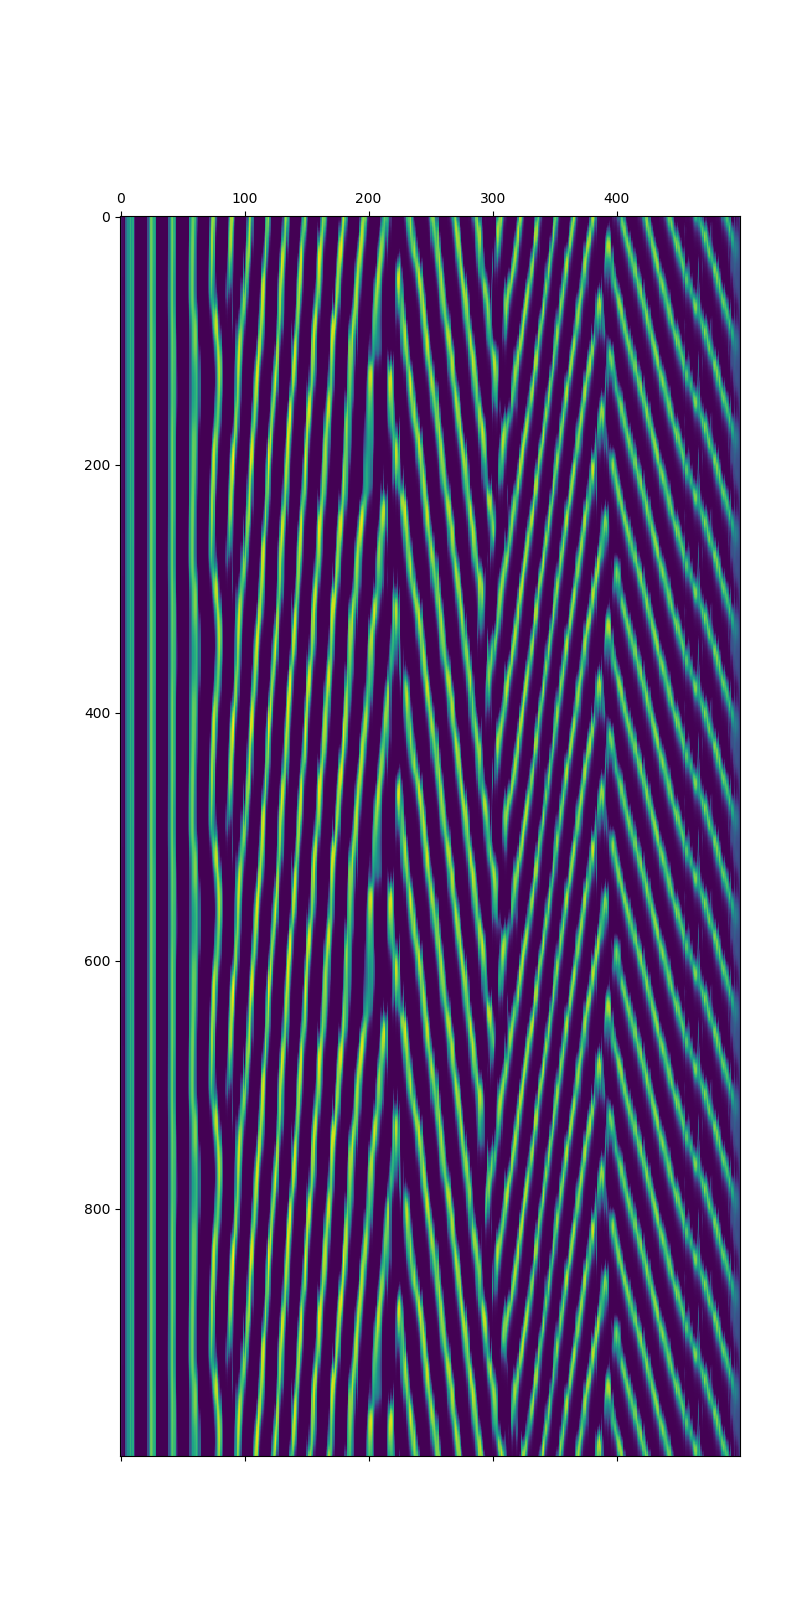

In [1752]:
plt.rcParams['figure.figsize'] = [2, 30]
plt.matshow(results[-1000:, :])
plt.show()


# interbumpDistances = compute_scales(np.transpose(results[:, 10:-10])/\
#                                     np.max(np.transpose(results[:, 10:-10]), axis=0, keepdims=True))
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(np.arange(interbumpDistances.shape[0]), (interbumpDistances))
# mod = 0.25
# plt.show()


<IPython.core.display.Javascript object>


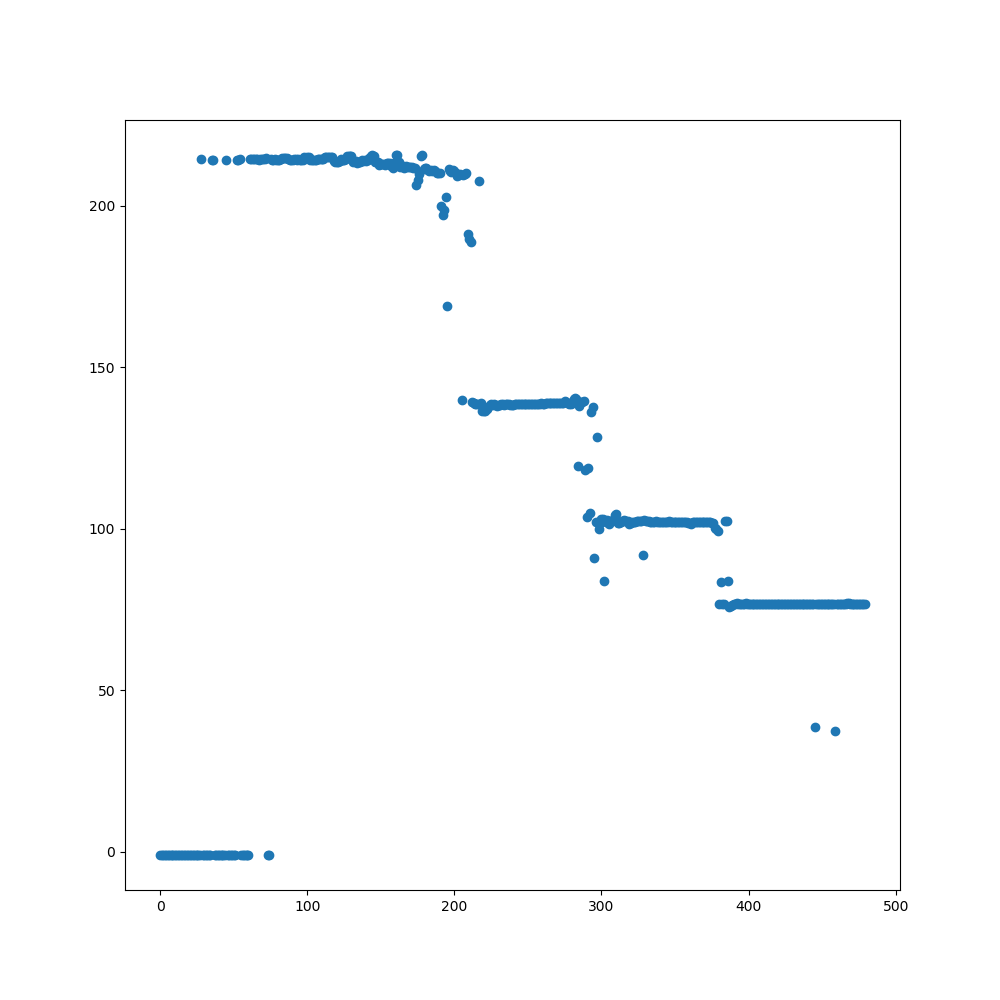

In [1753]:
plt.rcParams['figure.figsize'] = [10, 10]
activityScales = compute_scales(results[-1000:, 10:-10]/np.max(results[-1000:, 10:-10], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.show()

<IPython.core.display.Javascript object>


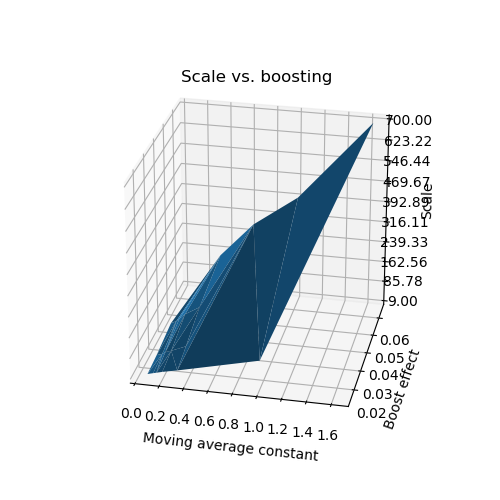

In [397]:
alphas = np.asarray([20,
                    10,
                    15,
                    5,
                    20,
                    20,
                    10,
                    15,
                    40,
                    40,
                    10,
                    5,
                    5,
                    40,
                    15,
                    0.5,
                    5.,
                    2.,
                    1.,
                    1.,
                    ])

boostEffects = np.asarray([100,
                          200,
                          200,
                          200,
                          200,
                          400,
                          100,
                          100,
                          100,
                          400,
                          400,
                          100,
                          400,
                          200,
                          400,
                          50,
                          50.,
                          50.,
                          50.,
                          400.,
                          ])

scales = np.asarray([43.75,
                    37.3,
                    30,
                    60,
                    21.6,
                    14.5,
                    74,
                    55,
                    33.5,
                    9,
                    23,
                    106.5,
                    34.5,
                    15,
                    17.5,
                    700,
                    150.,
                    282.,
                    400.,
                    103.,
                    ])


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(1./(alphas)**.7,
                       1./(boostEffects)**.7,
                       scales,
                       linewidth=0,
                       #cmap=cm.coolwarm,
                       antialiased=True)


ax.set_xlabel("Moving average constant")
ax.set_ylabel("Boost effect")
ax.set_zlabel("Scale")
plt.title("Scale vs. boosting")

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


ax.view_init(15, 210)
plt.savefig("ScaleSurface.png", dpi = 250)
plt.draw()
plt.show()

<IPython.core.display.Javascript object>


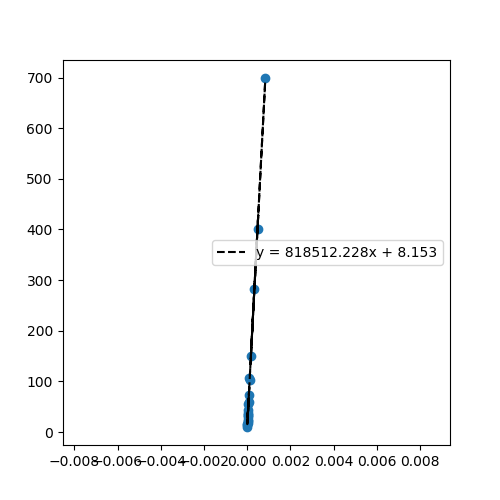

In [456]:
combinations = (1./(alphas/0.001) * 1./boostEffects)**0.7

plt.figure()
fit = np.polyfit(combinations,scales,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.scatter(combinations, scales)
plt.plot(combinations, fit_fn(combinations), '--k',
         label = "y = {0:4.3f}x + {1:4.3f}".format(fit_fn[1], fit_fn[0]))
plt.legend(loc="best")
plt.show()

In [1670]:
plt.rcParams['figure.figsize'] = [5, 15]
hatGCN.learningRate = 5000
for i in range(20):
    print(i, hatGCN.learningRate)
    hatGCN.learn(1, plotting=False, plotInterval=10)
    weights = hatGCN.placeWeights.cpu().numpy()
    with open("PlaceWeights{}.npz".format(i), "wb") as f:
        np.savez(f, weights)
    hatGCN.learningRate/=1.05

0 5000
Starting run 0
1 4761.9047619047615
Starting run 0


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


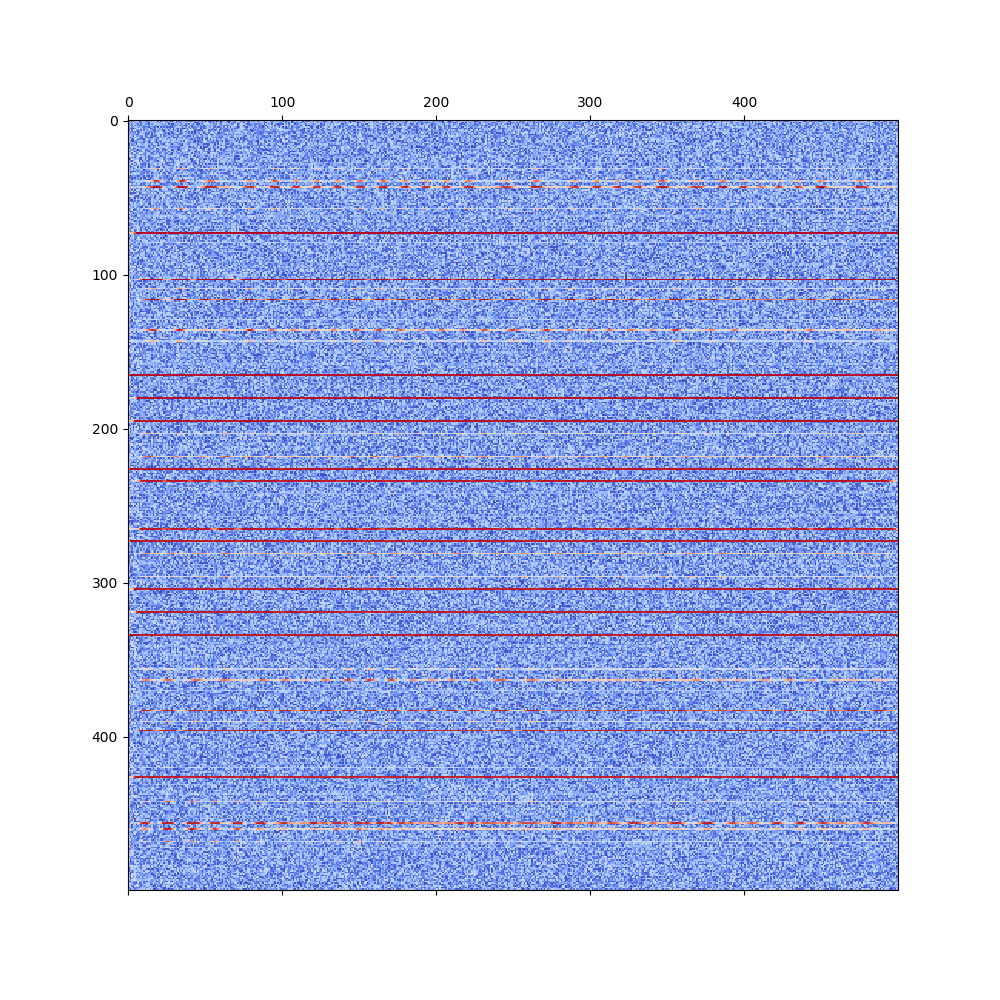

In [1672]:
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = plt.gca()
ax.matshow(torch.transpose(hatGCN.placeWeights, 0, 1).cpu().numpy()[:,],
                    cmap = plt.get_cmap("coolwarm"))
plt.show()

<IPython.core.display.Javascript object>


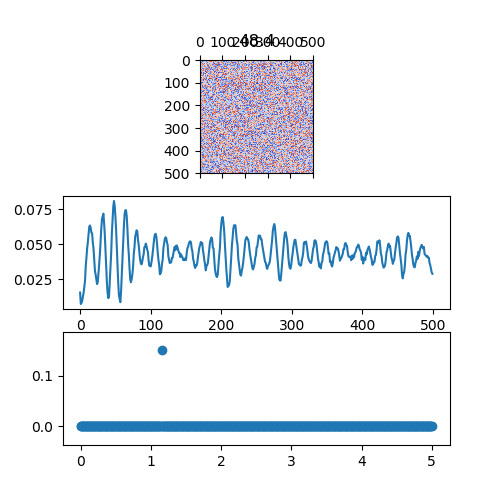

Starting run 0
Starting run 1
Starting run 2
Starting run 3
Starting run 4


KeyboardInterrupt: 

In [1675]:
plt.rcParams['figure.figsize'] = [5, 5]
hatGCN.learn(5000, plotting=True, plotInterval=10)

<IPython.core.display.Javascript object>


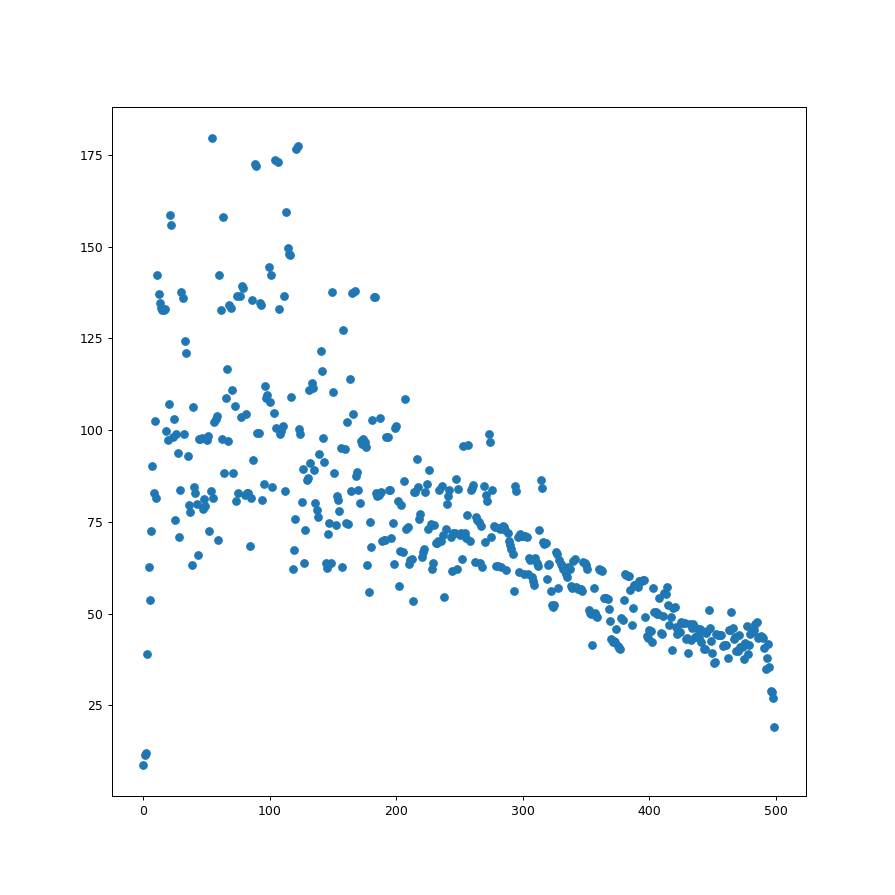

In [1007]:
weights = torch.transpose(GCN.placeWeights, 0, 1).cpu().numpy()
placeScales = compute_scales(weights[:, :]/np.max(weights[:, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(placeScales.shape[0]), placeScales)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

<IPython.core.display.Javascript object>


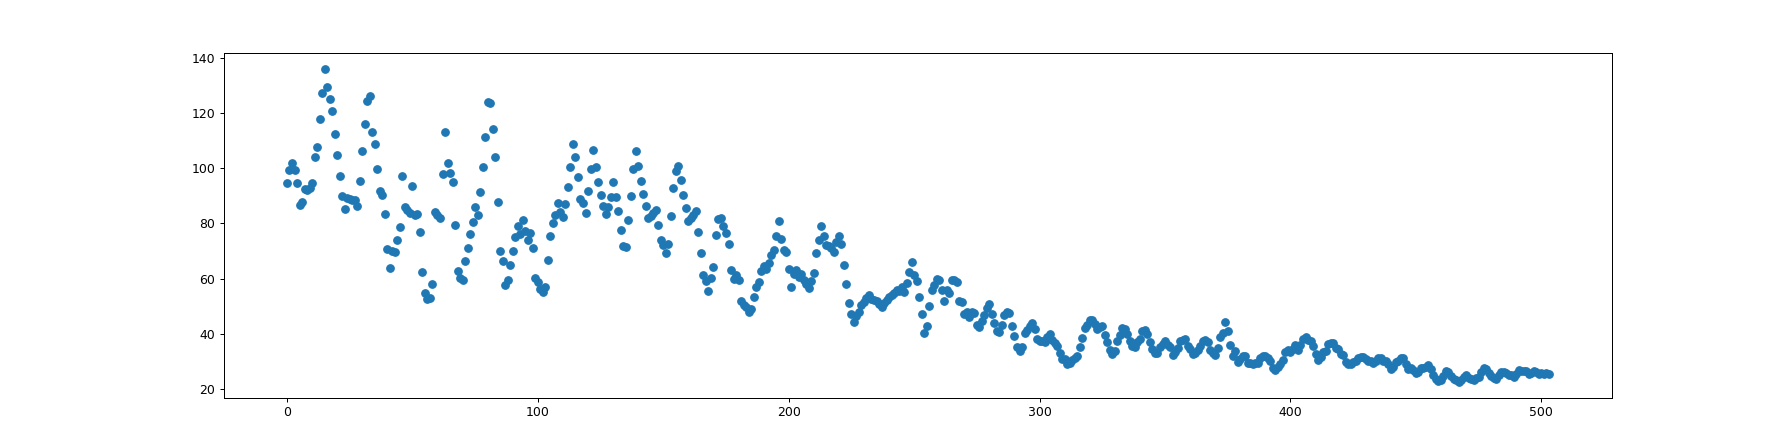

In [969]:
fig = plt.figure()
ax = plt.gca()
smoothed = smooth(placeScales,window_len=5, window="flat")
ax.scatter(np.arange(smoothed.shape[0]), smoothed)
mod = 0.25
#for i in range(10):
#    ax.axhline(mod/0.89146)
#    mod *= np.sqrt(2)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Scales')
ax1.set_ylabel('Scale (cm)', color=color)
ax1.scatter(np.arange(GCN.numX), 1./placeScales, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Boost effect (negative square root)', color=color)  # we already handled the x-label with ax1
ax2.scatter(np.arange(GCN.numX), np.power(GCN.boostEffect, 1/2.), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [ ]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.imshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
np.min(results)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", .01)

<video controls src="./test.mp4" />